# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

[Education](https://www.google.com/url?q=https://www.youtube.com/watch?v%3D9Y3yaoi9rUQ%26t%3D244s&sa=D&source=editors&ust=1737731704299888&usg=AOvVaw3DDA1bCHUKhDhCSUqO7c4A)

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
!pip install pandas_ta
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [ ]:

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2025-01-23'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8) #'2017-10-31' #

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date,
                 auto_adjust=False).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-01-25 A        45.550453   48.410000   48.419998   47.410000   47.599998   
           AAPL     28.218618   30.469999   30.525000   30.070000   30.105000   
           ABBV     43.563198   61.380001   61.630001   60.340000   60.599998   
           ABT      34.920330   40.310001   40.470001   39.250000   39.759998   
           ACGL     28.108561   29.559999   29.663334   29.370001   29.370001   
...                       ...         ...         ...         ...         ...   
2025-01-22 XYL     121.639999  121.639999  122.930000  121.040001  121.889999   
           YUM     126.220001  126.220001  126.779999  124.580002  125.360001   
           ZBH     109.720001  109.720001  111.150002  109.519997  110.250000   
           ZBRA    420.570007  420.570007  427.760010  419.589996  425.239990   
           ZTS     166.630005  166.630005  167.940002  164.729996  166.919998   

Price                   volume  
date       ticker               
2017-01-25 A         3073200.0  
           AAPL    129510400.0  
           ABBV      8052800.0  
           ABT      16890200.0  
           ACGL       708600.0  
...                        ...  
2025-01-22 XYL       1191000.0  
           YUM       2498900.0  
           ZBH       2320700.0  
           ZBRA       497500.0  
           ZTS       1610900.0  

[991584 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility (usually works in forex trading but for stocks as well)
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

Normalised the results (atr, macd and not rsi bbands, dollar vol) by subtracting mean and dividing by std deviation

return macd.sub(macd.mean()).div(macd.std())

This is to use the results in Machine Learning directly while clustering

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-01-25 A        45.550453   48.410000   48.419998   47.410000   47.599998   
           AAPL     28.218618   30.469999   30.525000   30.070000   30.105000   
           ABBV     43.563198   61.380001   61.630001   60.340000   60.599998   
           ABT      34.920330   40.310001   40.470001   39.250000   39.759998   
           ACGL     28.108561   29.559999   29.663334   29.370001   29.370001   
...                       ...         ...         ...         ...         ...   
2025-01-22 XYL     121.639999  121.639999  122.930000  121.040001  121.889999   
           YUM     126.220001  126.220001  126.779999  124.580002  125.360001   
           ZBH     109.720001  109.720001  111.150002  109.519997  110.250000   
           ZBRA    420.570007  420.570007  427.760010  419.589996  425.239990   
           ZTS     166.630005  166.630005  167.940002  164.729996  166.919998   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-01-25 A         3073200.0         -0.000526        NaN       NaN   
           AAPL    129510400.0         -0.001505        NaN       NaN   
           ABBV      8052800.0         -0.041865        NaN       NaN   
           ABT      16890200.0         -0.006039        NaN       NaN   
           ACGL       708600.0         -0.000695        NaN       NaN   
...                        ...               ...        ...       ...   
2025-01-22 XYL       1191000.0          0.000118  53.427084  4.739945   
           YUM       2498900.0          0.000135  38.804692  4.806860   
           ZBH       2320700.0          0.000100  56.994879  4.631476   
           ZBRA       497500.0          0.000139  62.862357  5.931586   
           ZTS       1610900.0          0.000185  46.552305  5.087134   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-01-25 A            NaN       NaN       NaN       NaN     139.985653  
           AAPL         NaN       NaN       NaN       NaN    3654.604556  
           ABBV         NaN       NaN       NaN       NaN     350.805722  
           ABT          NaN       NaN       NaN       NaN     589.811359  
           ACGL         NaN       NaN       NaN       NaN      19.917726  
...                     ...       ...       ...       ...            ...  
2025-01-22 XYL     4.773128  4.806310  0.308064 -0.446065     144.873239  
           YUM     4.872568  4.938276  0.570939 -2.016599     315.411161  
           ZBH     4.673698  4.715919 -0.572434  0.197629     254.627207  
           ZBRA    5.982118  6.032651  0.317484  0.401548     209.233579  
           ZTS     5.109254  5.131375  0.405375 -0.673247     268.424275  

[991584 rows x 14 columns]

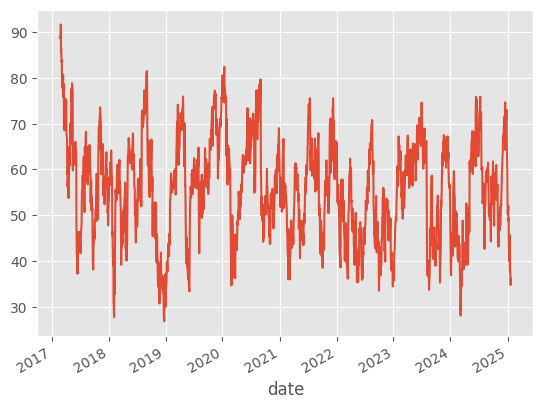

In [ ]:
# Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df.xs('AAPL', level=1)['rsi'].plot() # plot

# bolliager bands with 3 bands as lower middle and higher
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
df

# ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std()) # Normalization: (ATR - mean ) / std dev
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr) #if group_keys = True, you get double date columns and gets error after applying function
df

# MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# dollar volume
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
data = data[sorted(data.columns)]
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-03-31 A        49.870472 -1.503804  3.953520  3.893444  3.923482   
           AAPL     33.405495 -1.448536  3.542411  3.494620  3.518516   
           ABBV     46.245975 -1.893840  3.882335  3.835205  3.858770   
           ABT      38.472126 -1.671465  3.703670  3.672714  3.688192   
           ACGL     30.038885 -1.228376  3.448372  3.416247  3.432309   
...                       ...       ...       ...       ...       ...   
2025-01-31 XYL     121.639999  0.308064  4.806310  4.739945  4.773128   
           YUM     126.220001  0.570939  4.938276  4.806860  4.872568   
           ZBH     109.720001 -0.572434  4.715919  4.631476  4.673698   
           ZBRA    420.570007  0.317484  6.032651  5.931586  5.982118   
           ZTS     166.630005  0.405375  5.131375  5.087134  5.109254   

                   dollar_volume  garman_klass_vol      macd        rsi  
date       ticker                                                        
2017-03-31 A           88.072272         -0.001462  0.147327  58.227735  
           AAPL      3195.355939         -0.002012 -0.071984  73.035669  
           ABBV       286.839376         -0.046622  0.060504  59.564515  
           ABT        253.027792         -0.007699 -0.104092  51.923919  
           ACGL        26.653848         -0.001097 -0.105398  57.894176  
...                          ...               ...       ...        ...  
2025-01-31 XYL        150.654242          0.000118 -0.446065  53.427084  
           YUM        255.535927          0.000135 -2.016599  38.804692  
           ZBH        188.156171          0.000100  0.197629  56.994879  
           ZBRA       152.766335          0.000139  0.401548  62.862357  
           ZTS        481.217496          0.000185 -0.673247  46.552305  

[46867 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-03-31 A        49.870472 -1.503804  3.953520  3.893444  3.923482   
           AAPL     33.405495 -1.448536  3.542411  3.494620  3.518516   
           ABBV     46.245975 -1.893840  3.882335  3.835205  3.858770   
           ABT      38.472126 -1.671465  3.703670  3.672714  3.688192   
           ACGL     30.038885 -1.228376  3.448372  3.416247  3.432309   
...                       ...       ...       ...       ...       ...   
2025-01-31 XYL     121.639999  0.308064  4.806310  4.739945  4.773128   
           YUM     126.220001  0.570939  4.938276  4.806860  4.872568   
           ZBH     109.720001 -0.572434  4.715919  4.631476  4.673698   
           ZBRA    420.570007  0.317484  6.032651  5.931586  5.982118   
           ZTS     166.630005  0.405375  5.131375  5.087134  5.109254   

                   dollar_volume  garman_klass_vol      macd        rsi  \
date       ticker                                                         
2017-03-31 A                 NaN         -0.001462  0.147327  58.227735   
           AAPL              NaN         -0.002012 -0.071984  73.035669   
           ABBV              NaN         -0.046622  0.060504  59.564515   
           ABT               NaN         -0.007699 -0.104092  51.923919   
           ACGL              NaN         -0.001097 -0.105398  57.894176   
...                          ...               ...       ...        ...   
2025-01-31 XYL        123.760697          0.000118 -0.446065  53.427084   
           YUM        203.290963          0.000135 -2.016599  38.804692   
           ZBH        179.375522          0.000100  0.197629  56.994879   
           ZBRA       125.676263          0.000139  0.401548  62.862357   
           ZTS        348.222110          0.000185 -0.673247  46.552305   

                   dollar_vol_rank  
date       ticker                   
2017-03-31 A                   NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
           ACGL                NaN  
...                            ...  
2025-01-31 XYL               393.0  
           YUM               269.0  
           ZBH               295.0  
           ZBRA              387.0  
           ZTS               149.0  

[46867 rows x 10 columns]

In [ ]:

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-02-28 AAPL     42.073761 -1.084746  3.790357  3.612313  3.701335   
           ABBV     84.961655  1.616494  4.504274  4.385019  4.444647   
           ABT      53.386944 -0.841307  4.031637  3.927706  3.979671   
           ACN     145.122116 -0.773886  5.018637  4.920223  4.969430   
           ADBE    209.130005 -1.076841  5.371634  5.223541  5.297587   
...                       ...       ...       ...       ...       ...   
2025-01-31 WDAY    253.479996  0.389755  5.611853  5.485749  5.548801   
           WFC      77.540001  1.667884  4.366701  4.224868  4.295785   
           WMT      93.230003  2.619472  4.549003  4.507109  4.528056   
           XOM     109.529999  0.359680  4.730813  4.656262  4.693538   
           ZTS     166.630005  0.405375  5.131375  5.087134  5.109254   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2018-02-28 AAPL           -0.001436 -0.090613  59.836020  
           ABBV           -0.043210  0.961096  56.507225  
           ABT            -0.006197 -0.048601  55.823924  
           ACN            -0.004935  0.100610  54.875614  
           ADBE            0.000190  0.379571  63.581744  
...                             ...       ...        ...  
2025-01-31 WDAY            0.000378 -0.942629  47.370414  
           WFC             0.000075  1.424777  66.121525  
           WMT             0.000113  0.156693  57.818041  
           XOM             0.000104 -0.319924  46.066645  
           ZTS             0.000185 -0.673247  46.552305  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [ ]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2019-02-28 AAPL     41.522587 -1.209711  3.766797  3.711479  3.739138   
           ABBV     60.694588 -0.847004  4.146309  4.113748  4.130028   
           ABT      69.935852 -0.767165  4.265600  4.180565  4.223082   
           ACN     148.080276 -1.188160  5.014949  4.953239  4.984094   
           ADBE    262.500000 -1.022976  5.586458  5.522007  5.554233   
...                       ...       ...       ...       ...       ...   
2025-01-31 VZ       38.950001 -0.641110  3.709794  3.658412  3.684103   
           WDAY    253.479996  0.389755  5.611853  5.485749  5.548801   
           WFC      77.540001  1.667884  4.366701  4.224868  4.295785   
           WMT      93.230003  2.619472  4.549003  4.507109  4.528056   
           XOM     109.529999  0.359680  4.730813  4.656262  4.693538   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2019-02-28 AAPL           -0.000838  0.015848  57.086852   0.044777   
           ABBV           -0.027962 -0.654784  42.829407  -0.013078   
           ABT            -0.003495  0.961806  64.682822   0.063579   
           ACN            -0.002613  0.372327  63.334359   0.050993   
           ADBE            0.000144  0.384913  62.690361   0.059237   
...                             ...       ...        ...        ...   
2025-01-31 VZ              0.000184 -1.207645  43.334443  -0.008747   
           WDAY            0.000378 -0.942629  47.370414  -0.017634   
           WFC             0.000075  1.424777  66.121525   0.103929   
           WMT             0.000113  0.156693  57.818041   0.031876   
           XOM             0.000104 -0.319924  46.066645   0.018221   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-02-28 AAPL     0.049952  -0.008827  -0.042896  -0.007195   -0.001098  
           ABBV    -0.067224  -0.052407  -0.027746  -0.020785   -0.027379  
           ABT      0.038322   0.017386   0.026726   0.027655    0.022756  
           ACN      0.069793  -0.006403  -0.006223   0.004976    0.001683  
           ADBE     0.077159   0.015193  -0.000640   0.005758    0.019122  
...                      ...        ...        ...        ...         ...  
2025-01-31 VZ      -0.054481  -0.020101  -0.001076   0.003954   -0.001527  
           WDAY     0.006956   0.027233   0.018470   0.003911   -0.011457  
           WFC      0.008953   0.063035   0.047924   0.032395    0.039187  
           WMT      0.005050   0.044694   0.053245   0.052455    0.045866  
           XOM     -0.036395  -0.018464  -0.010490  -0.005814    0.008104  

[10362 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-02-28 AAPL     0.034  0.0175 -0.0271  0.0012 -0.0160   0.044777
           ABBV     0.034  0.0175 -0.0271  0.0012 -0.0160  -0.013078
           ABT      0.034  0.0175 -0.0271  0.0012 -0.0160   0.063579
           ACN      0.034  0.0175 -0.0271  0.0012 -0.0160   0.050993
           ADBE     0.034  0.0175 -0.0271  0.0012 -0.0160   0.059237
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ       0.065  0.0478 -0.0005 -0.0261 -0.0217   0.052457
           WDAY     0.065  0.0478 -0.0005 -0.0261 -0.0217   0.069019
           WFC      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.180051
           WMT      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.128580
           XOM      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.018405

[10080 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]
valid_stocks
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-02-28 AAPL     0.034  0.0175 -0.0271  0.0012 -0.0160   0.044777
           ABBV     0.034  0.0175 -0.0271  0.0012 -0.0160  -0.013078
           ABT      0.034  0.0175 -0.0271  0.0012 -0.0160   0.063579
           ACN      0.034  0.0175 -0.0271  0.0012 -0.0160   0.050993
           ADBE     0.034  0.0175 -0.0271  0.0012 -0.0160   0.059237
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ       0.065  0.0478 -0.0005 -0.0261 -0.0217   0.052457
           WDAY     0.065  0.0478 -0.0005 -0.0261 -0.0217   0.069019
           WFC      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.180051
           WMT      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.128580
           XOM      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.018405

[10041 rows x 6 columns]

* Calculate Rolling Factor Betas.

Rolling OLS python

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-02-28 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-11-30 VZ      0.885481 -0.606878  0.299134  0.505724  0.276441
           WDAY    0.760453 -1.023488  0.151870 -2.489189 -0.729128
           WFC     0.723451 -0.312080  1.429827 -2.012391 -1.095391
           WMT     0.844560  0.175825 -0.332756  1.279651  0.295548
           XOM     0.614447  0.031140  0.205420  1.179330  0.728192

[10041 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10141 entries, (Timestamp('2019-02-28 00:00:00'), 'AAPL') to (Timestamp('2025-01-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10141 non-null  float64
 1   bb_high           10141 non-null  float64
 2   bb_low            10141 non-null  float64
 3   bb_mid            10141 non-null  float64
 4   garman_klass_vol  10141 non-null  float64
 5   macd              10141 non-null  float64
 6   rsi               10141 non-null  float64
 7   return_1m         10141 non-null  float64
 8   return_2m         10141 non-null  float64
 9   return_3m         10141 non-null  float64
 10  return_6m         10141 non-null  float64
 11  return_9m         10141 non-null  float64
 12  return_12m        10141 non-null  float64
 13  Mkt-RF            10141 non-null  float64
 14  SMB               10141 non-null  float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [ ]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_ # initial_centroids
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2019-02-28 AAPL   -1.209711  3.766797  3.711479  3.739138         -0.000838   
           ABBV   -0.847004  4.146309  4.113748  4.130028         -0.027962   
           ABT    -0.767165  4.265600  4.180565  4.223082         -0.003495   
           ACN    -1.188160  5.014949  4.953239  4.984094         -0.002613   
           ADBE   -1.022976  5.586458  5.522007  5.554233          0.000144   
...                     ...       ...       ...       ...               ...   
2025-01-31 VZ     -0.641110  3.709794  3.658412  3.684103          0.000184   
           WDAY    0.389755  5.611853  5.485749  5.548801          0.000378   
           WFC     1.667884  4.366701  4.224868  4.295785          0.000075   
           WMT     2.619472  4.549003  4.507109  4.528056          0.000113   
           XOM     0.359680  4.730813  4.656262  4.693538          0.000104   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2019-02-28 AAPL    0.015848  57.086852   0.044777   0.049952  -0.008827   
           ABBV   -0.654784  42.829407  -0.013078  -0.067224  -0.052407   
           ABT     0.961806  64.682822   0.063579   0.038322   0.017386   
           ACN     0.372327  63.334359   0.050993   0.069793  -0.006403   
           ADBE    0.384913  62.690361   0.059237   0.077159   0.015193   
...                     ...        ...        ...        ...        ...   
2025-01-31 VZ     -1.207645  43.334443  -0.008747  -0.054481  -0.020101   
           WDAY   -0.942629  47.370414  -0.017634   0.006956   0.027233   
           WFC     1.424777  66.121525   0.103929   0.008953   0.063035   
           WMT     0.156693  57.818041   0.031876   0.005050   0.044694   
           XOM    -0.319924  46.066645   0.018221  -0.036395  -0.018464   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-02-28 AAPL    -0.042896  -0.007195   -0.001098  1.281449 -0.203745   
           ABBV    -0.027746  -0.020785   -0.027379  0.551608  0.255495   
           ABT      0.026726   0.027655    0.022756  0.762770 -0.026957   
           ACN     -0.006223   0.004976    0.001683  1.202407 -0.211609   
           ADBE    -0.000640   0.005758    0.019122  1.328622 -0.585595   
...                      ...        ...         ...       ...       ...   
2025-01-31 VZ      -0.001076   0.003954   -0.001527  0.471297 -0.496445   
           WDAY     0.018470   0.003911   -0.011457  1.192083 -0.619860   
           WFC      0.047924   0.032395    0.039187  1.117691 -0.121112   
           WMT      0.053245   0.052455    0.045866  0.645061 -0.350259   
           XOM     -0.010490  -0.005814    0.008104  0.989760  0.018837   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-02-28 AAPL   -0.640983  0.307270  0.452658        3  
           ABBV   -0.137449  0.375689  0.509534        2  
           ABT    -0.436312  0.140258  1.018994        0  
           ACN    -0.216548  0.361135 -0.014245        0  
           ADBE   -0.247235  0.314271 -0.415795        0  
...                     ...       ...       ...      ...  
2025-01-31 VZ      0.321955  0.128187  0.060995        1  
           WDAY   -0.376370 -0.851604 -0.331677        2  
           WFC     1.607122 -0.666223 -1.045284        0  
           WMT    -0.322067  0.188299  0.572000        3  
           XOM     0.931844 -0.467256  0.334235        2  

[10141 rows x 19 columns]

In [ ]:
data.xs('2023-09-30')

atr   bb_high    bb_low    bb_mid  garman_klass_vol      macd  \
ticker                                                                       
AAPL    0.623780  5.232513  5.117915  5.175214          0.000080 -1.513579   
ABBV   -0.139675  5.005608  4.934242  4.969925         -0.002037  0.331950   
ABT    -0.210362  4.630400  4.540757  4.585578         -0.000633 -1.802855   
ACN     0.691684  5.787858  5.697456  5.742657          0.000173 -0.736218   
ADBE    0.519938  6.370012  6.200930  6.285471          0.000300 -0.884131   
...          ...       ...       ...       ...               ...       ...   
VZ     -1.136698  3.478114  3.405923  3.442019         -0.004577 -0.691955   
WDAY    0.368262  5.577169  5.381854  5.479512          0.000146 -1.034523   
WFC    -0.849780  3.765223  3.678345  3.721784         -0.000527 -0.496687   
WMT    -0.363331  4.014887  3.980271  3.997579         -0.000169 -0.182404   
XOM     0.719101  4.753832  4.690317  4.722075         -0.000974  1.435616   

              rsi  return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker                                                                     
AAPL    40.176353  -0.088678  -0.065818  -0.040319   0.006736   0.031618   
ABBV    48.572019   0.014290  -0.001740   0.038074  -0.007753  -0.005672   
ABT     35.666746  -0.058795  -0.067296  -0.037153  -0.005776  -0.012271   
ACN     44.571331  -0.051456  -0.014712  -0.000384   0.013325   0.017053   
ADBE    44.502143  -0.088390  -0.033774   0.014055   0.047775   0.047252   
...           ...        ...        ...        ...        ...        ...   
VZ      38.328137  -0.073471  -0.024809  -0.039156  -0.024383  -0.016041   
WDAY    36.580489  -0.121268  -0.048137  -0.016564   0.006596   0.028164   
WFC     42.307807  -0.010414  -0.055487  -0.011858   0.017586   0.001276   
WMT     46.929477  -0.016481   0.001995   0.006989   0.014874   0.014754   
XOM     58.863427   0.057469   0.051383   0.033937   0.014528   0.009869   

        return_12m    Mkt-RF       SMB       HML       RMW       CMA  cluster  
ticker                                                                         
AAPL      0.018511  1.189766 -0.176585 -0.222104  0.243793 -0.128347        3  
ABBV      0.012132  0.454237  0.091540 -0.458896  0.492115  1.183007        1  
ABT       0.001662  0.743814  0.244898 -0.385842  0.611585  0.858256        3  
ACN       0.016215  1.225204 -0.407603 -0.266278  0.363103 -0.094146        1  
ADBE      0.051920  1.608677 -1.062004  0.414666  0.186668 -0.929068        1  
...            ...       ...       ...       ...       ...       ...      ...  
VZ       -0.007626  0.298959 -0.212272  0.358963  0.328329 -0.016563        3  
WDAY      0.029134  1.084344 -0.921188 -0.609249 -0.859246 -0.207682        3  
WFC       0.003686  1.130268  0.322855  1.988391 -0.416301 -1.457800        3  
WMT       0.018902  0.747723 -0.284930 -0.443585 -0.137456  0.590009        1  
XOM       0.027894  0.996162 -1.039315  1.691438 -0.669415 -0.285604        2  

[143 rows x 19 columns]

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return


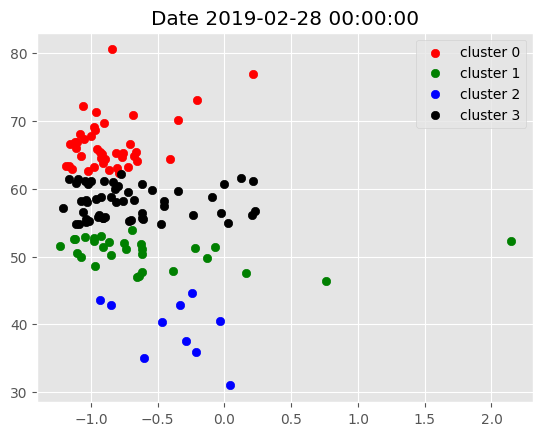

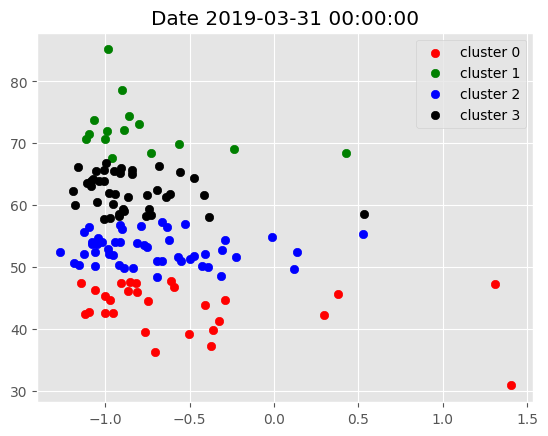

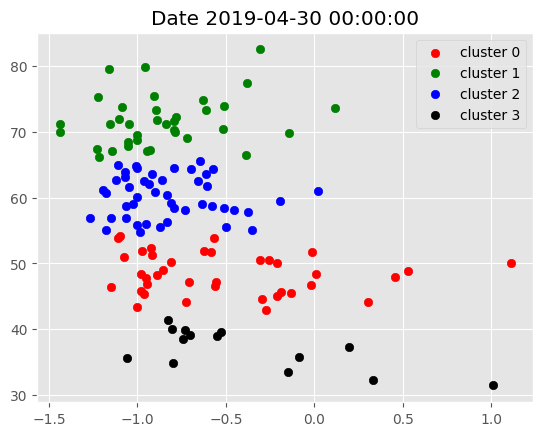

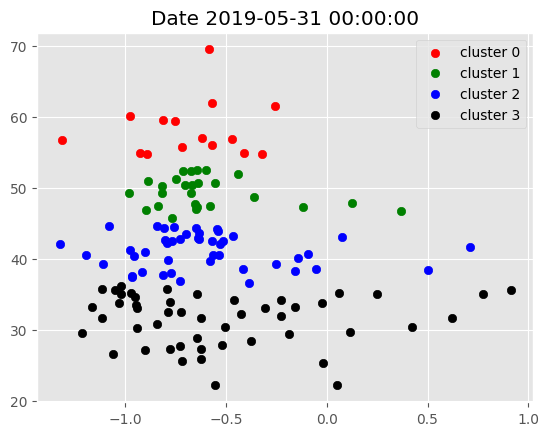

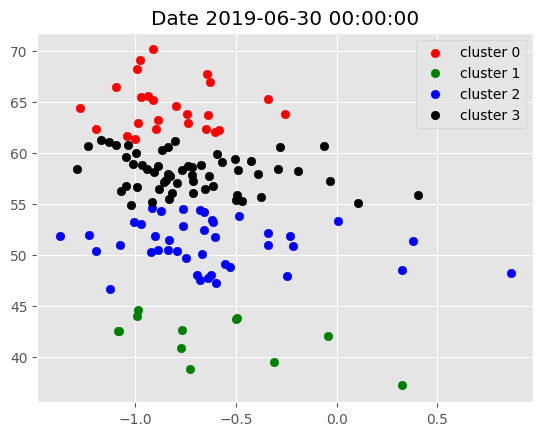

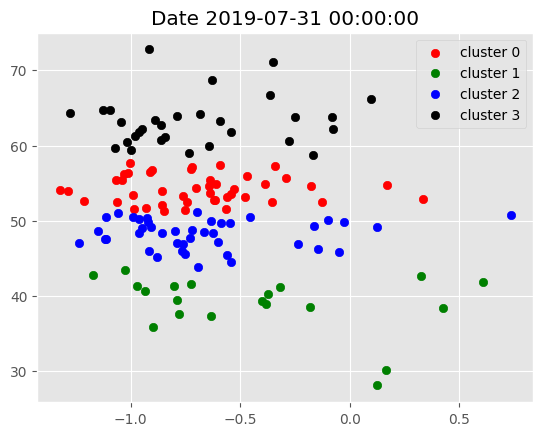

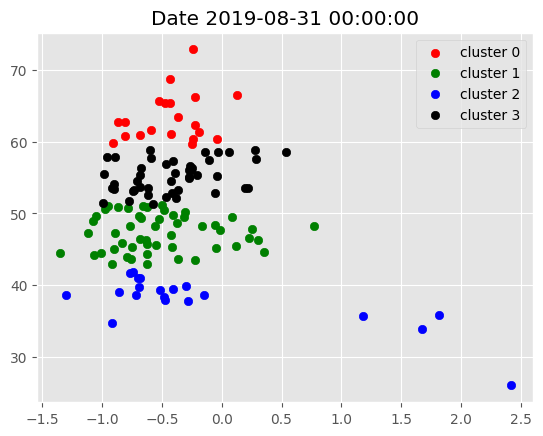

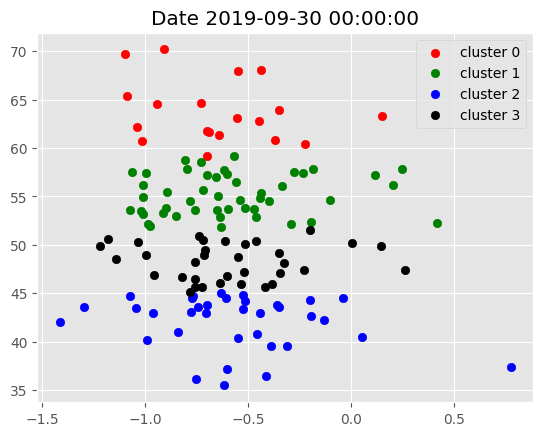

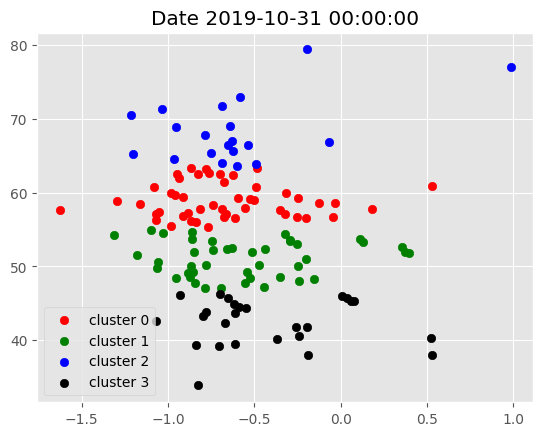

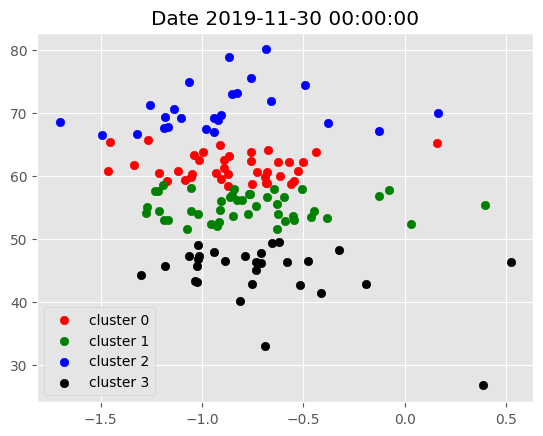

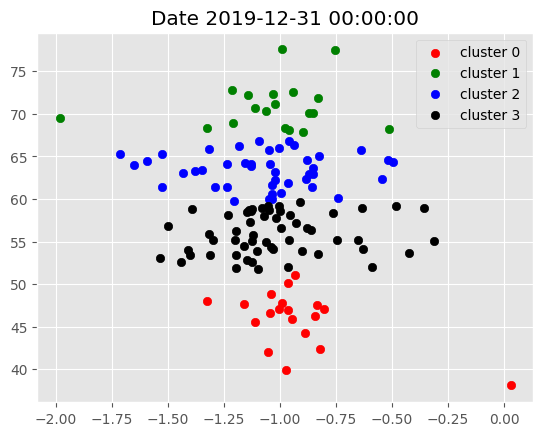

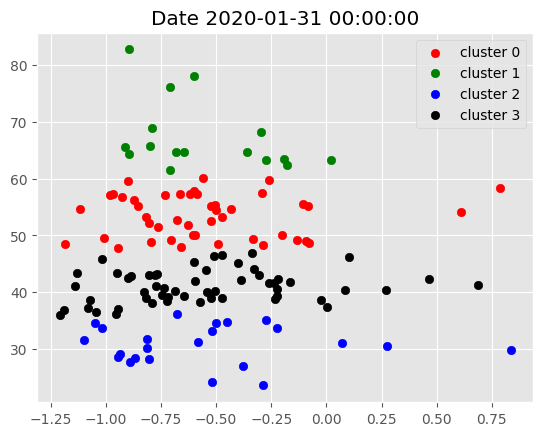

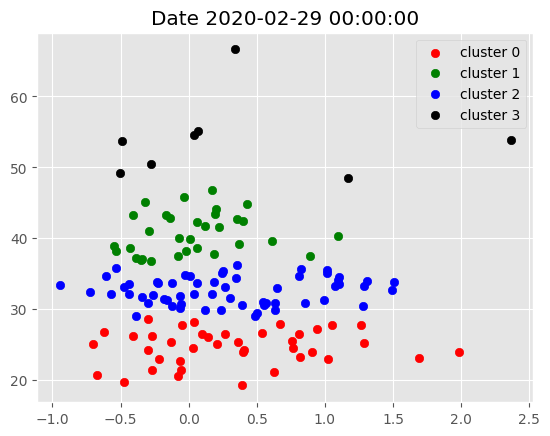

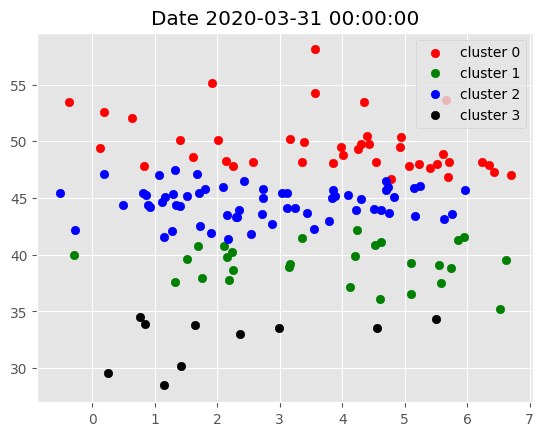

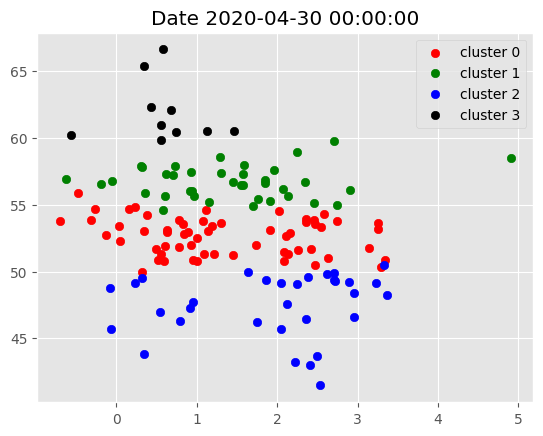

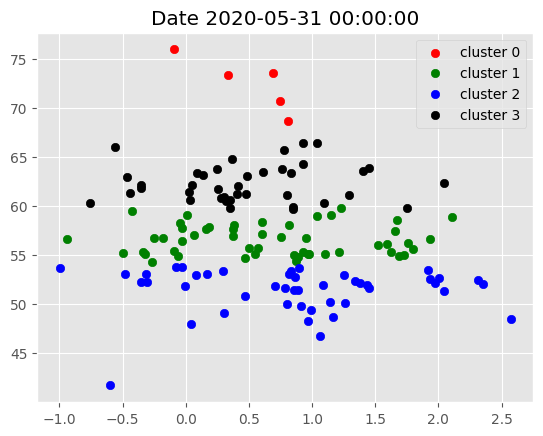

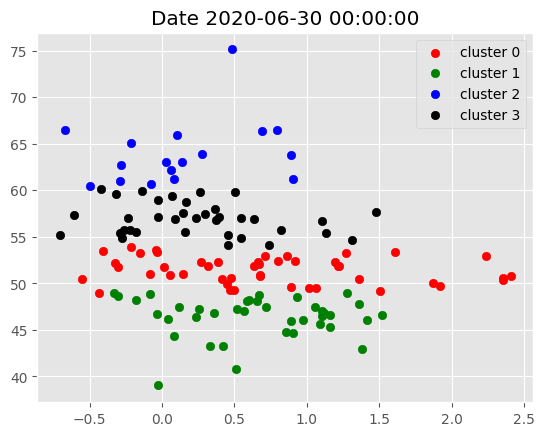

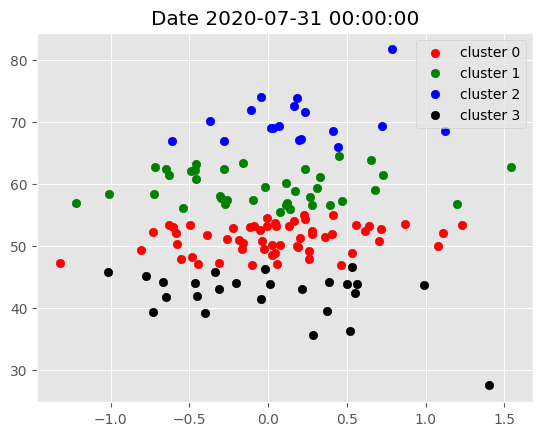

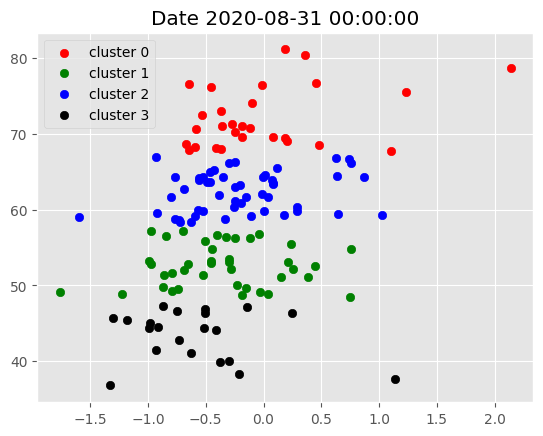

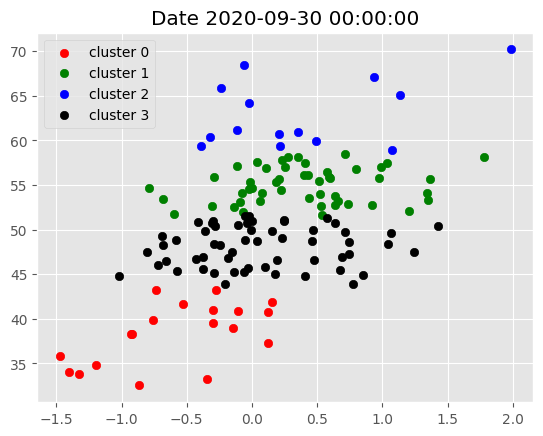

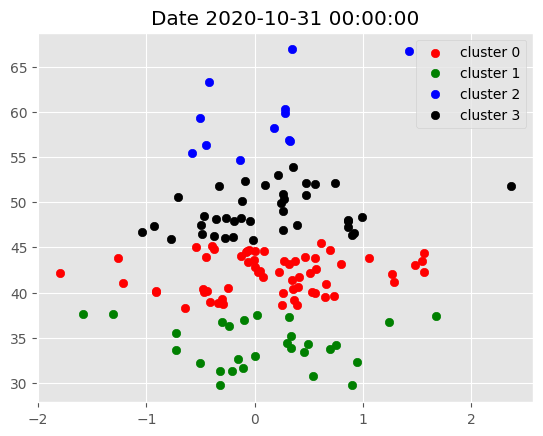

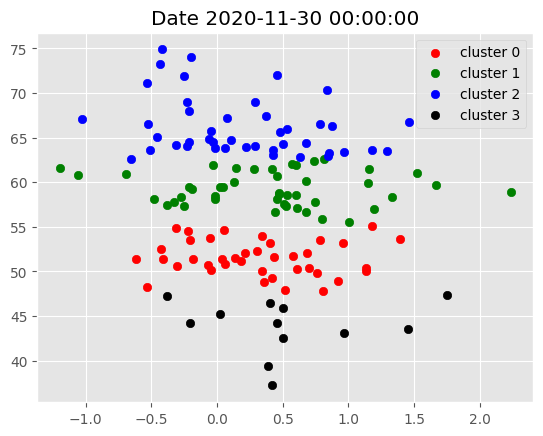

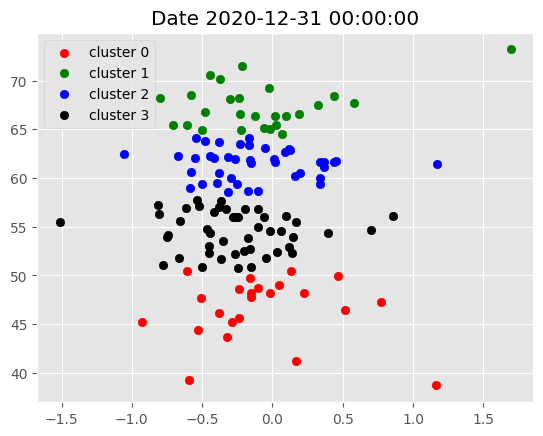

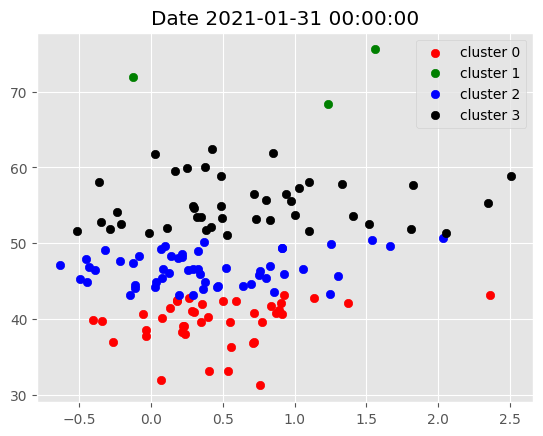

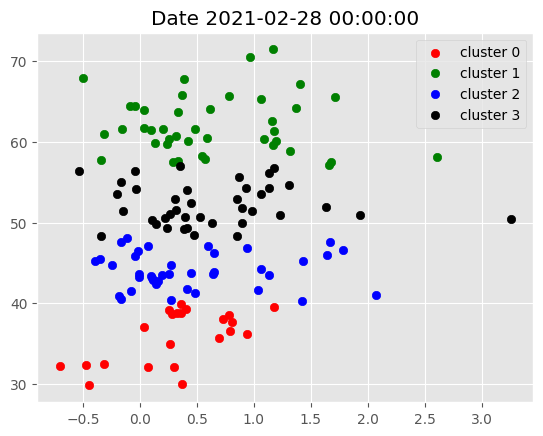

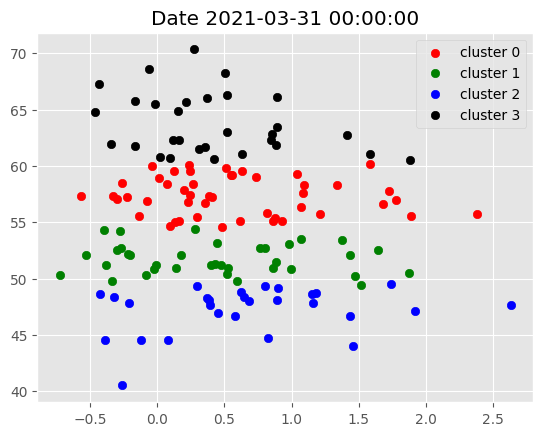

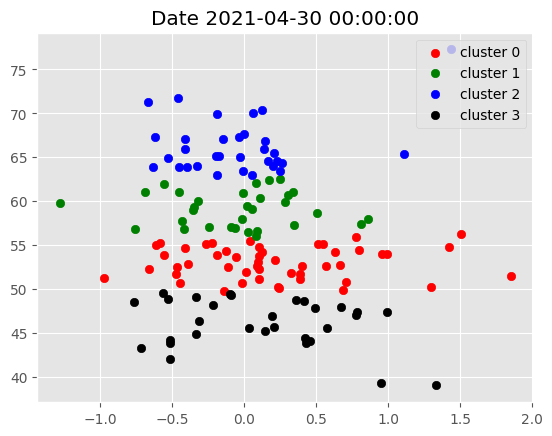

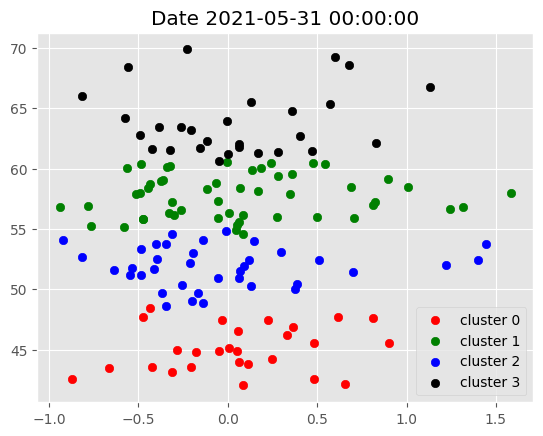

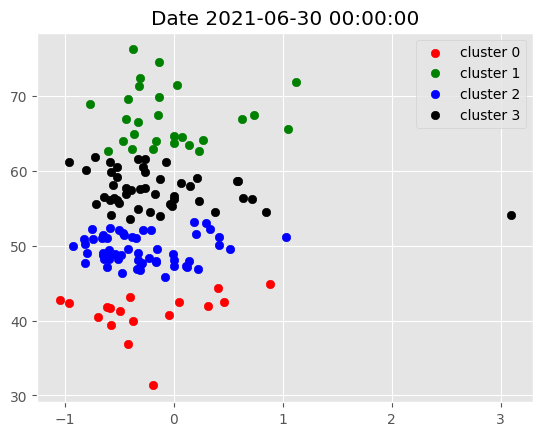

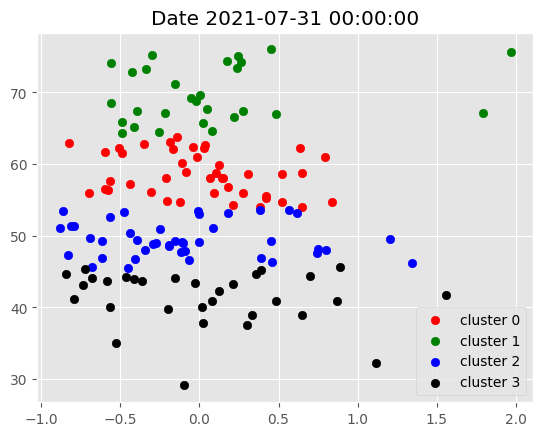

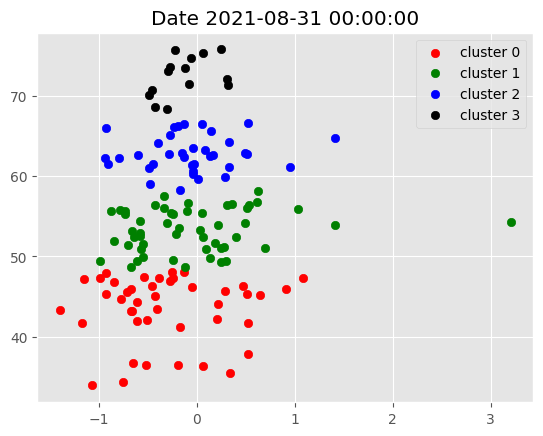

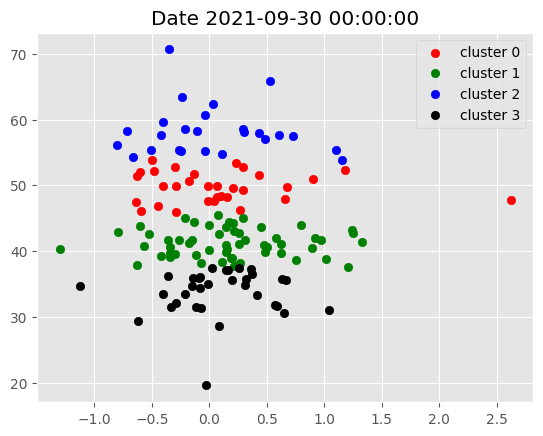

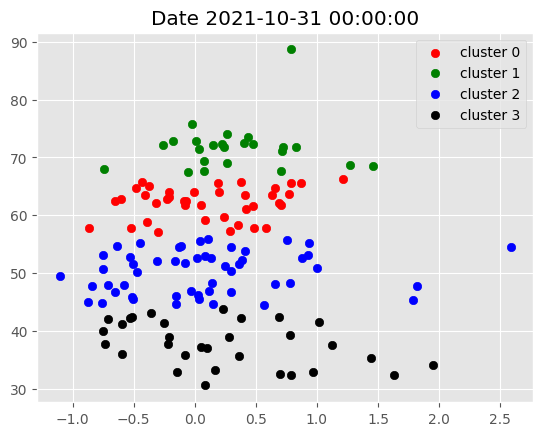

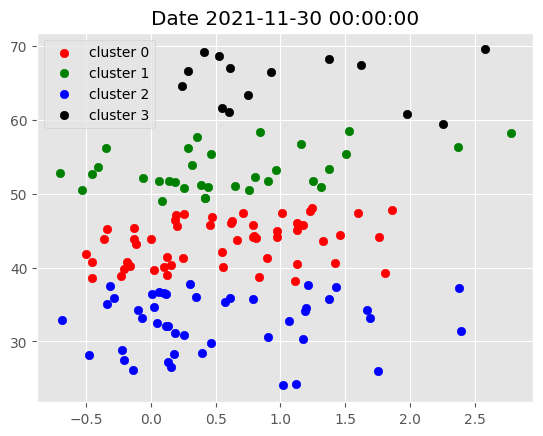

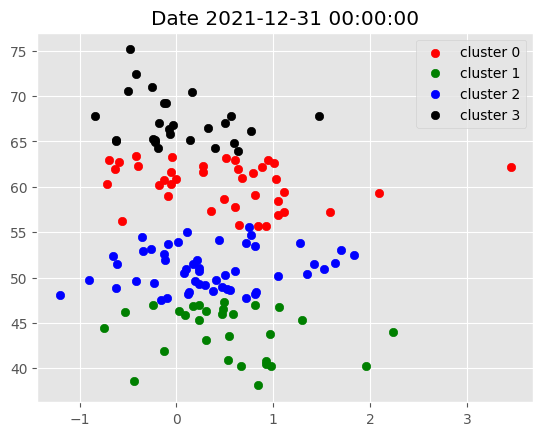

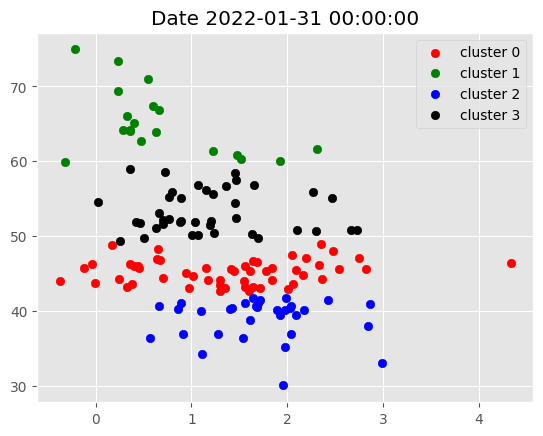

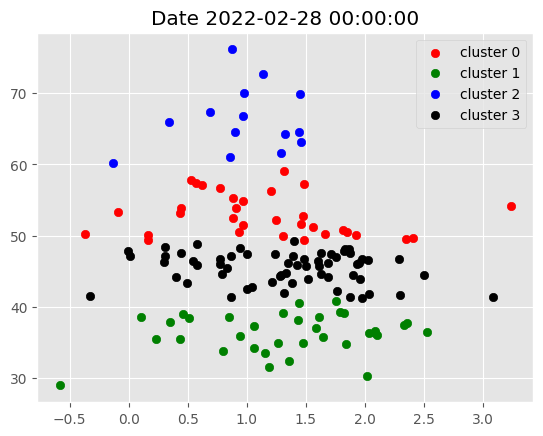

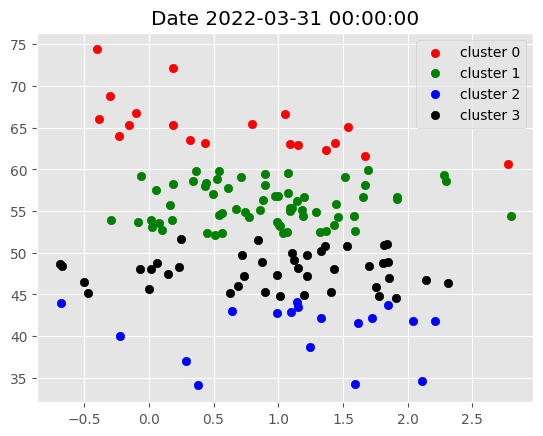

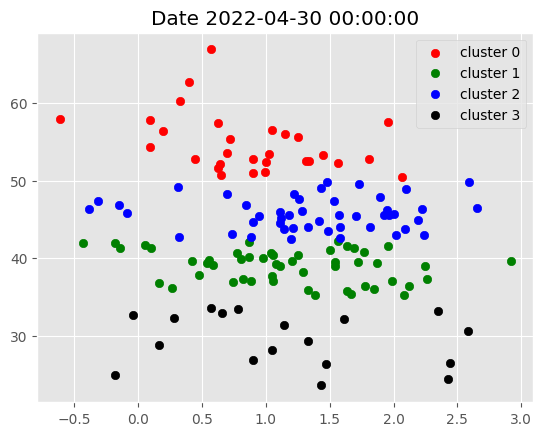

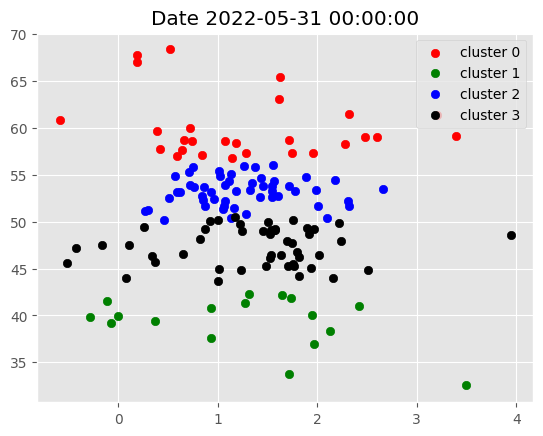

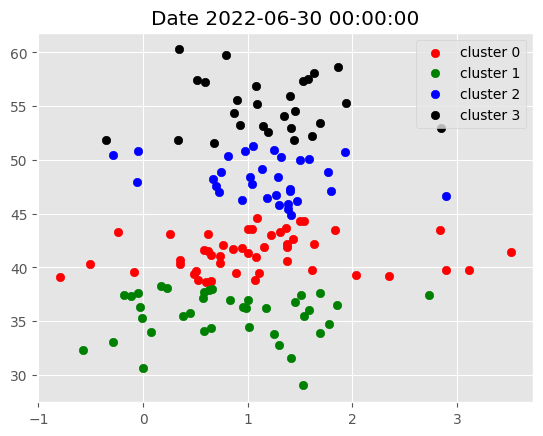

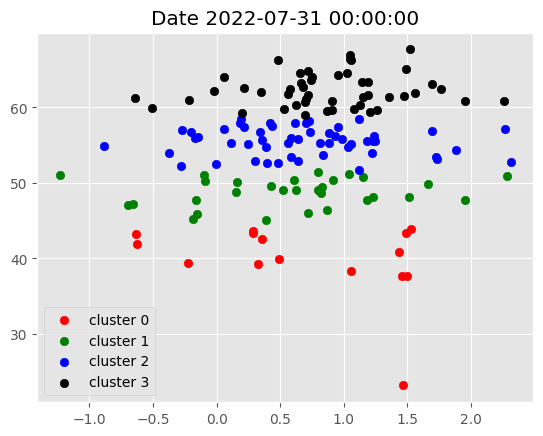

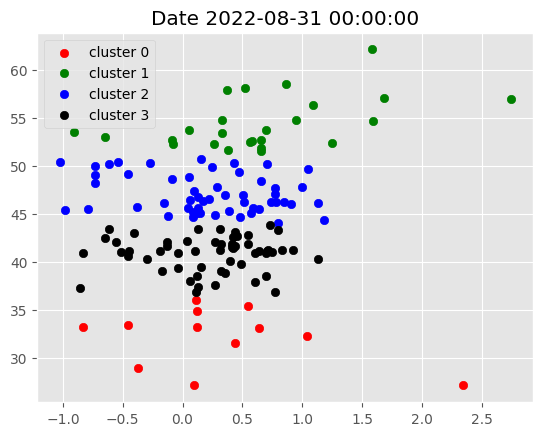

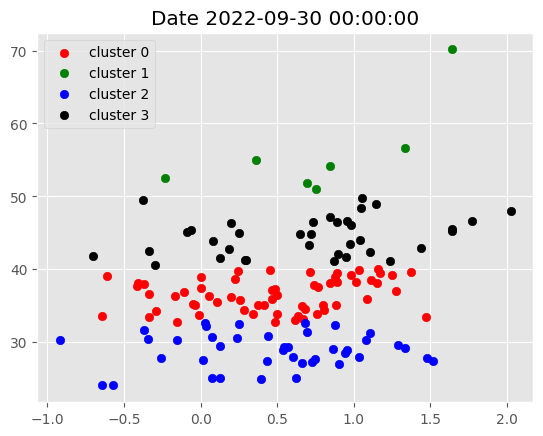

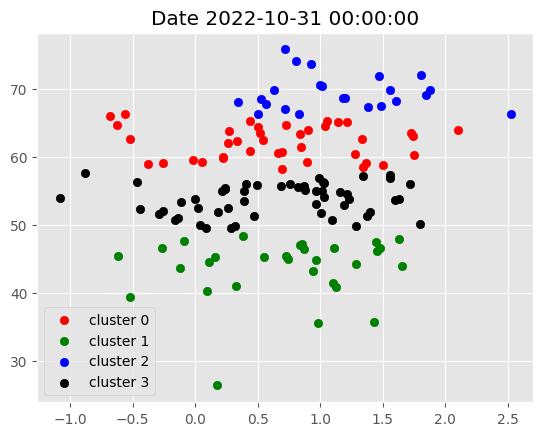

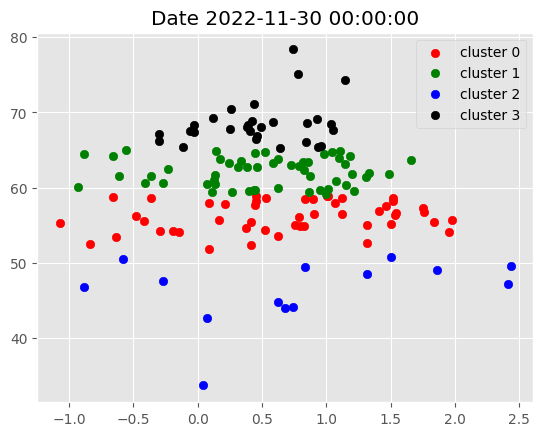

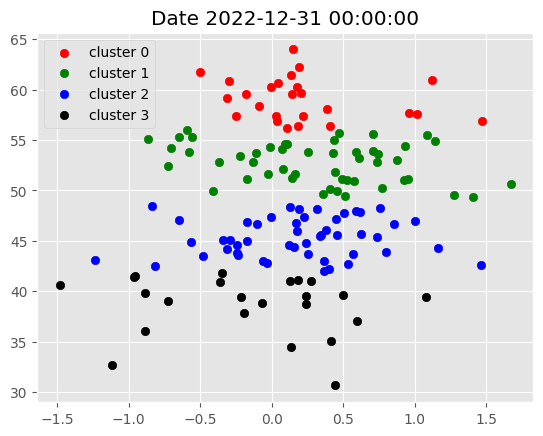

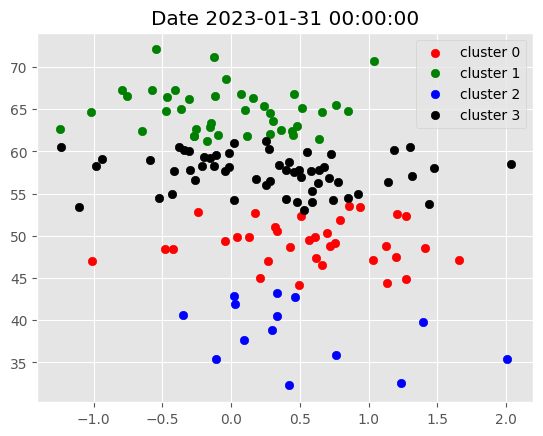

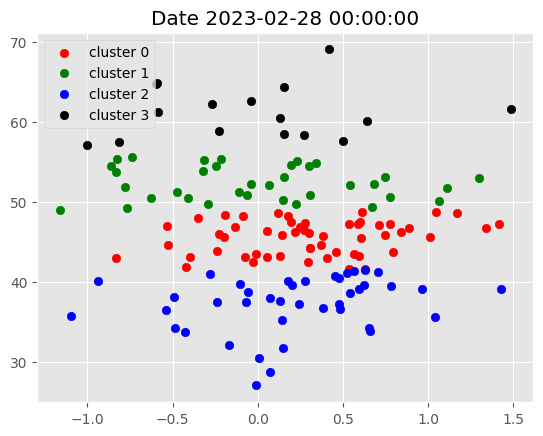

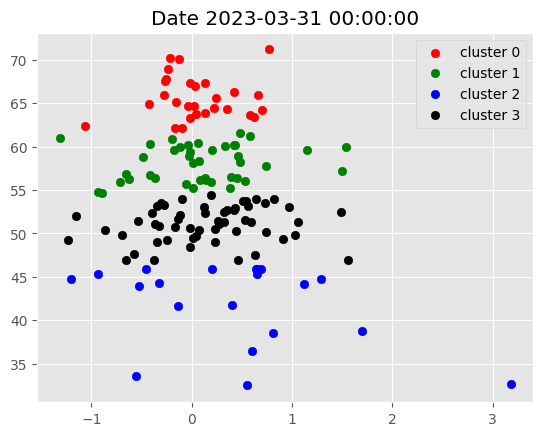

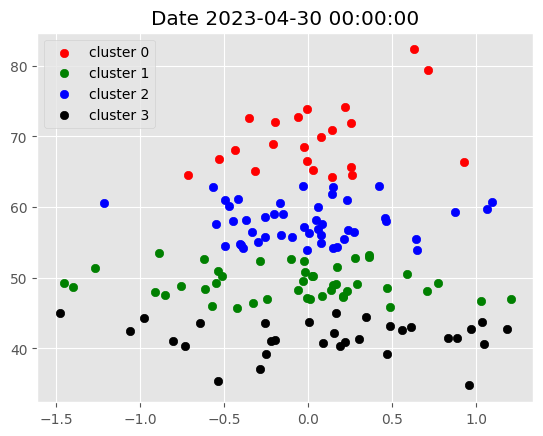

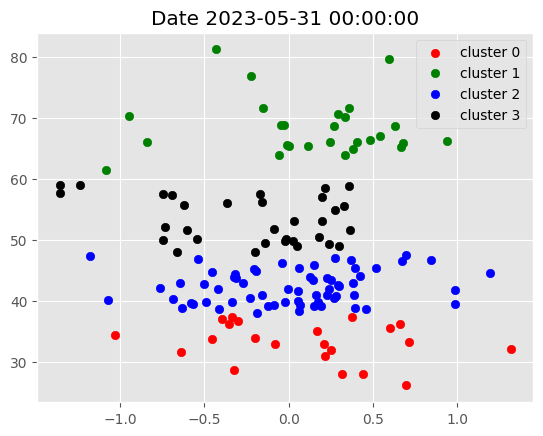

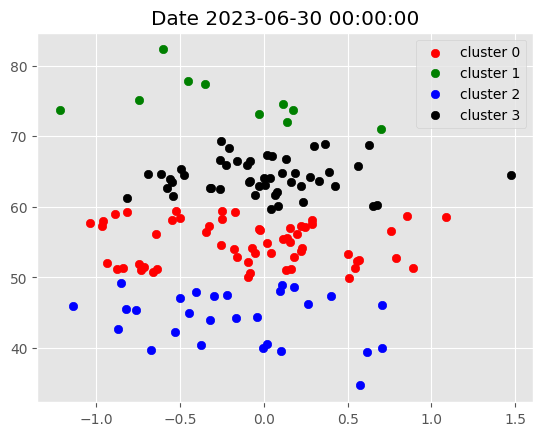

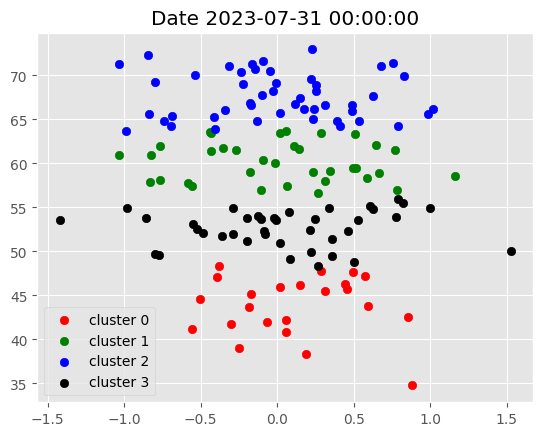

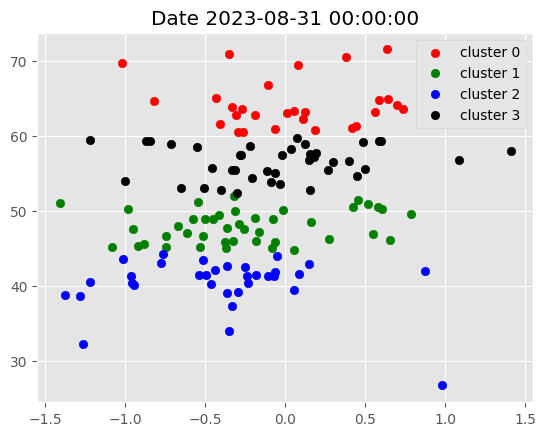

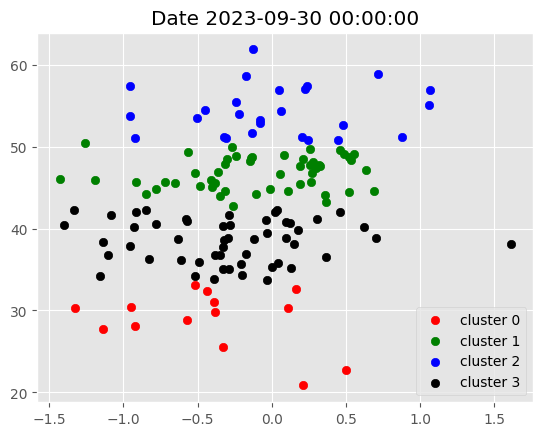

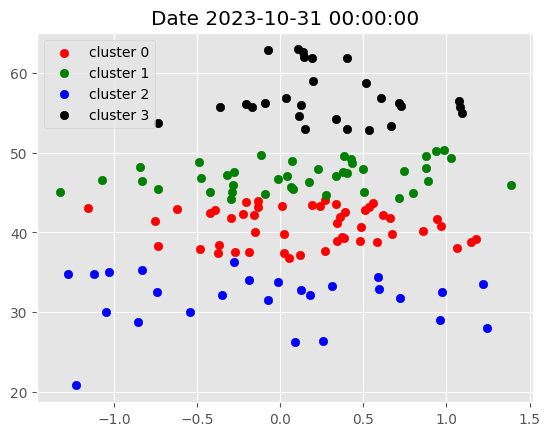

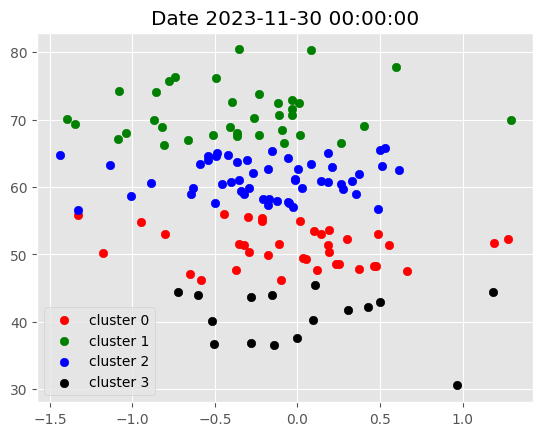

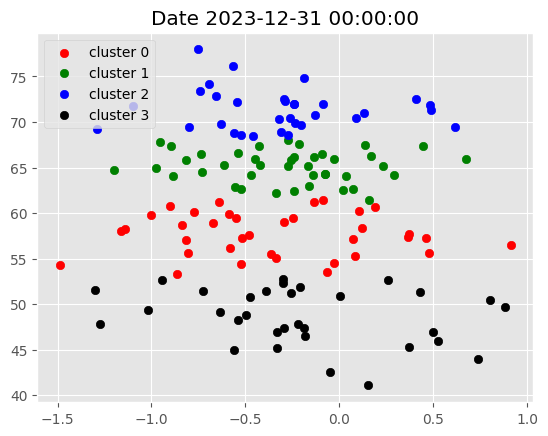

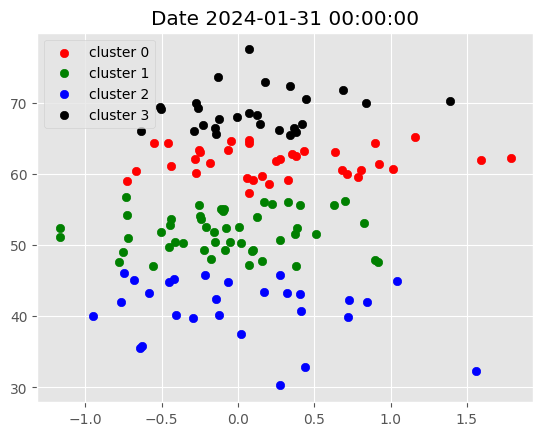

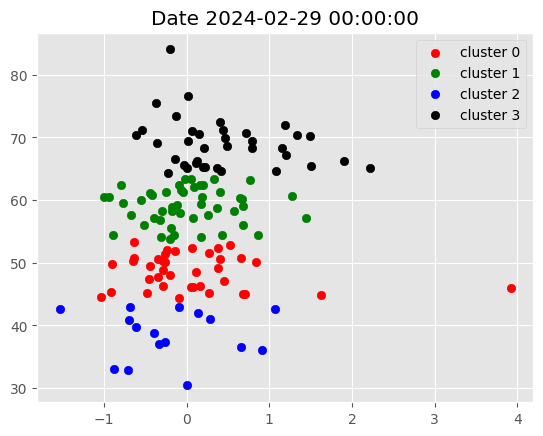

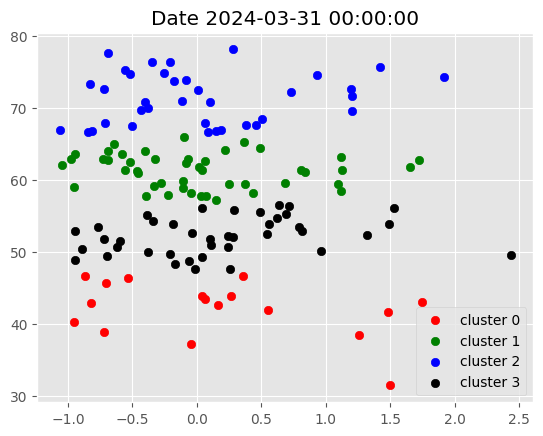

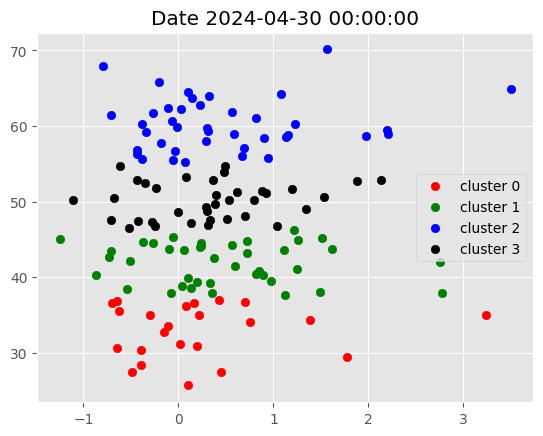

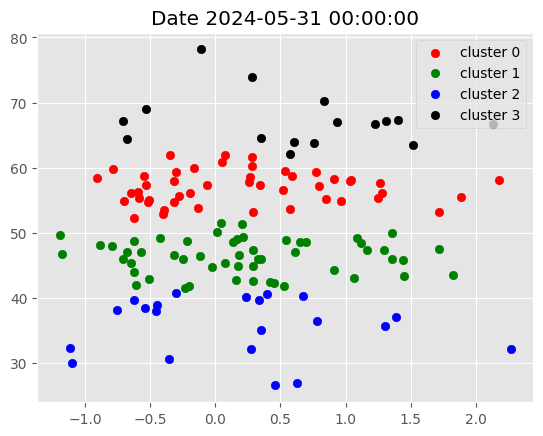

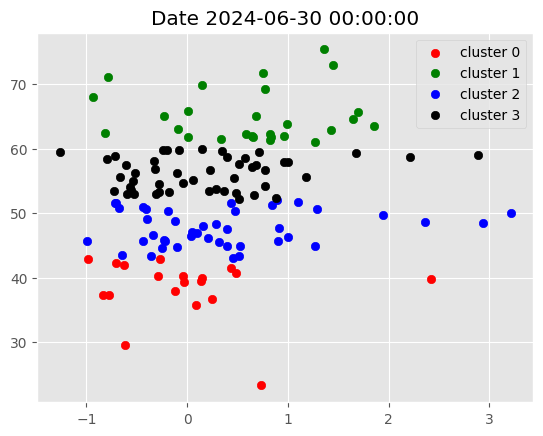

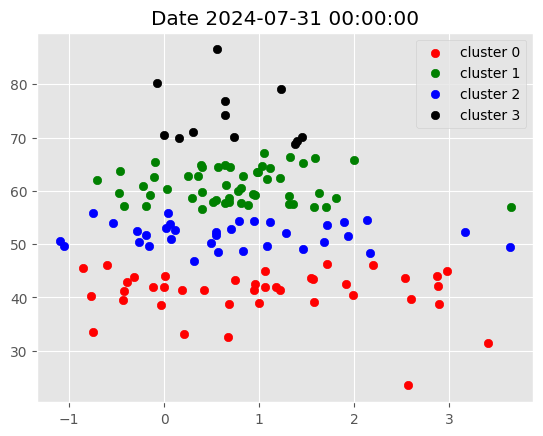

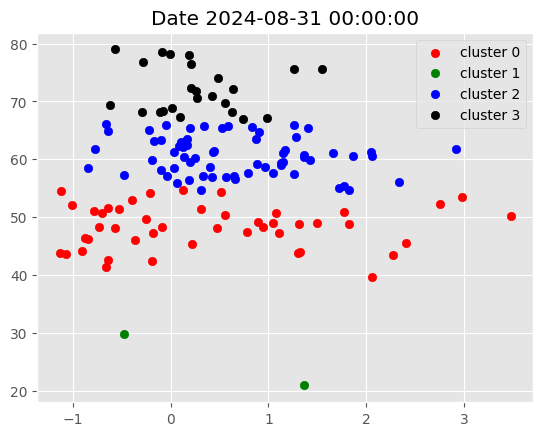

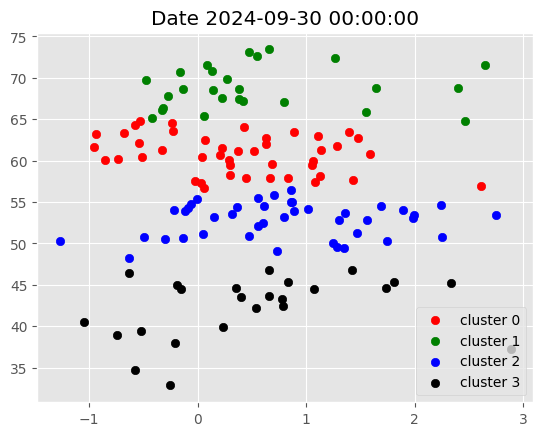

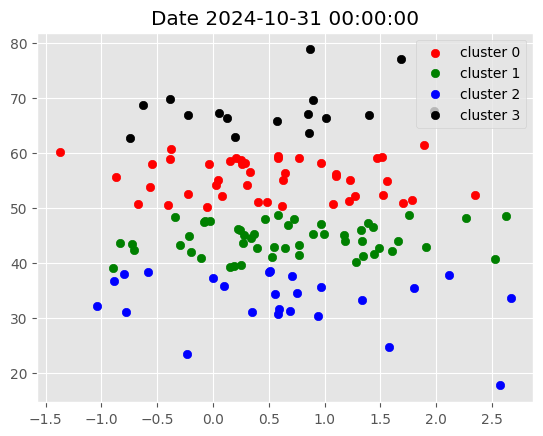

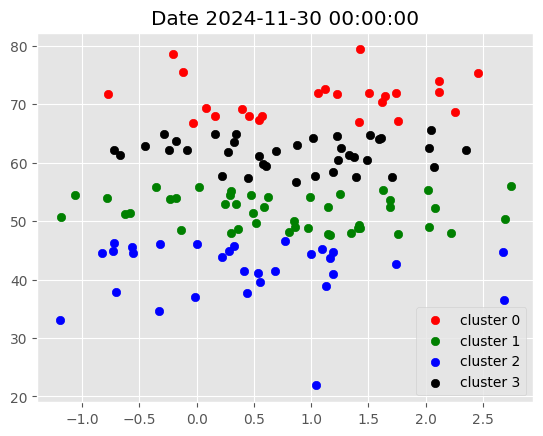

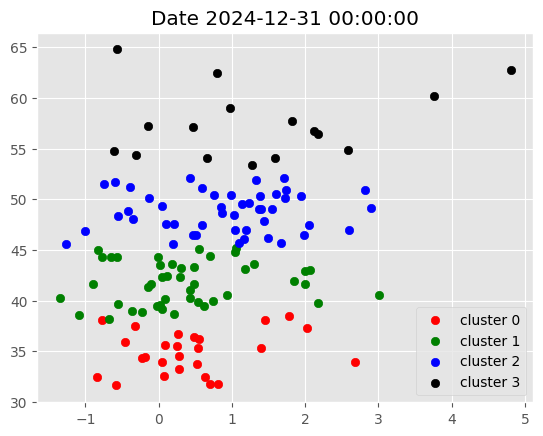

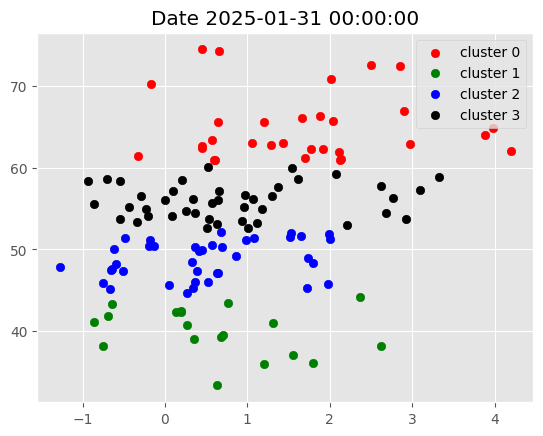

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist(): # for each month in date col., rsi is used for clustering to check stocks momentum

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

    #higher rsi clusters with good stocks momentum 60 to 70, 75.

### Apply pre-defined centroids.

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18)) # as 18 is the no. of features or columns we have

initial_centroids[:, 6] = target_rsi_values # as 7th column is rsi col in dataset

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [ ]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_ # initial_centroids
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2019-02-28 AAPL   -1.209711  3.766797  3.711479  3.739138         -0.000838   
           ABBV   -0.847004  4.146309  4.113748  4.130028         -0.027962   
           ABT    -0.767165  4.265600  4.180565  4.223082         -0.003495   
           ACN    -1.188160  5.014949  4.953239  4.984094         -0.002613   
           ADBE   -1.022976  5.586458  5.522007  5.554233          0.000144   
...                     ...       ...       ...       ...               ...   
2025-01-31 VZ     -0.641110  3.709794  3.658412  3.684103          0.000184   
           WDAY    0.389755  5.611853  5.485749  5.548801          0.000378   
           WFC     1.667884  4.366701  4.224868  4.295785          0.000075   
           WMT     2.619472  4.549003  4.507109  4.528056          0.000113   
           XOM     0.359680  4.730813  4.656262  4.693538          0.000104   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2019-02-28 AAPL    0.015848  57.086852   0.044777   0.049952  -0.008827   
           ABBV   -0.654784  42.829407  -0.013078  -0.067224  -0.052407   
           ABT     0.961806  64.682822   0.063579   0.038322   0.017386   
           ACN     0.372327  63.334359   0.050993   0.069793  -0.006403   
           ADBE    0.384913  62.690361   0.059237   0.077159   0.015193   
...                     ...        ...        ...        ...        ...   
2025-01-31 VZ     -1.207645  43.334443  -0.008747  -0.054481  -0.020101   
           WDAY   -0.942629  47.370414  -0.017634   0.006956   0.027233   
           WFC     1.424777  66.121525   0.103929   0.008953   0.063035   
           WMT     0.156693  57.818041   0.031876   0.005050   0.044694   
           XOM    -0.319924  46.066645   0.018221  -0.036395  -0.018464   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-02-28 AAPL    -0.042896  -0.007195   -0.001098  1.281449 -0.203745   
           ABBV    -0.027746  -0.020785   -0.027379  0.551608  0.255495   
           ABT      0.026726   0.027655    0.022756  0.762770 -0.026957   
           ACN     -0.006223   0.004976    0.001683  1.202407 -0.211609   
           ADBE    -0.000640   0.005758    0.019122  1.328622 -0.585595   
...                      ...        ...         ...       ...       ...   
2025-01-31 VZ      -0.001076   0.003954   -0.001527  0.471297 -0.496445   
           WDAY     0.018470   0.003911   -0.011457  1.192083 -0.619860   
           WFC      0.047924   0.032395    0.039187  1.117691 -0.121112   
           WMT      0.053245   0.052455    0.045866  0.645061 -0.350259   
           XOM     -0.010490  -0.005814    0.008104  0.989760  0.018837   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-02-28 AAPL   -0.640983  0.307270  0.452658        2  
           ABBV   -0.137449  0.375689  0.509534        0  
           ABT    -0.436312  0.140258  1.018994        3  
           ACN    -0.216548  0.361135 -0.014245        3  
           ADBE   -0.247235  0.314271 -0.415795        3  
...                     ...       ...       ...      ...  
2025-01-31 VZ      0.321955  0.128187  0.060995        0  
           WDAY   -0.376370 -0.851604 -0.331677        1  
           WFC     1.607122 -0.666223 -1.045284        3  
           WMT    -0.322067  0.188299  0.572000        2  
           XOM     0.931844 -0.467256  0.334235        1  

[10141 rows x 19 columns]

In [ ]:
data.xs('2023-09-30')

atr   bb_high    bb_low    bb_mid  garman_klass_vol      macd  \
ticker                                                                       
AAPL    0.623780  5.232513  5.117915  5.175214          0.000080 -1.513579   
ABBV   -0.139675  5.005608  4.934242  4.969925         -0.002037  0.331950   
ABT    -0.210362  4.630400  4.540757  4.585578         -0.000633 -1.802855   
ACN     0.691684  5.787858  5.697456  5.742657          0.000173 -0.736218   
ADBE    0.519938  6.370012  6.200930  6.285471          0.000300 -0.884131   
...          ...       ...       ...       ...               ...       ...   
VZ     -1.136698  3.478114  3.405923  3.442019         -0.004577 -0.691955   
WDAY    0.368262  5.577169  5.381854  5.479512          0.000146 -1.034523   
WFC    -0.849780  3.765223  3.678345  3.721784         -0.000527 -0.496687   
WMT    -0.363331  4.014887  3.980271  3.997579         -0.000169 -0.182404   
XOM     0.719101  4.753832  4.690317  4.722075         -0.000974  1.435616   

              rsi  return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker                                                                     
AAPL    40.176353  -0.088678  -0.065818  -0.040319   0.006736   0.031618   
ABBV    48.572019   0.014290  -0.001740   0.038074  -0.007753  -0.005672   
ABT     35.666746  -0.058795  -0.067296  -0.037153  -0.005776  -0.012271   
ACN     44.571331  -0.051456  -0.014712  -0.000384   0.013325   0.017053   
ADBE    44.502143  -0.088390  -0.033774   0.014055   0.047775   0.047252   
...           ...        ...        ...        ...        ...        ...   
VZ      38.328137  -0.073471  -0.024809  -0.039156  -0.024383  -0.016041   
WDAY    36.580489  -0.121268  -0.048137  -0.016564   0.006596   0.028164   
WFC     42.307807  -0.010414  -0.055487  -0.011858   0.017586   0.001276   
WMT     46.929477  -0.016481   0.001995   0.006989   0.014874   0.014754   
XOM     58.863427   0.057469   0.051383   0.033937   0.014528   0.009869   

        return_12m    Mkt-RF       SMB       HML       RMW       CMA  cluster  
ticker                                                                         
AAPL      0.018511  1.189766 -0.176585 -0.222104  0.243793 -0.128347        1  
ABBV      0.012132  0.454237  0.091540 -0.458896  0.492115  1.183007        2  
ABT       0.001662  0.743814  0.244898 -0.385842  0.611585  0.858256        0  
ACN       0.016215  1.225204 -0.407603 -0.266278  0.363103 -0.094146        1  
ADBE      0.051920  1.608677 -1.062004  0.414666  0.186668 -0.929068        1  
...            ...       ...       ...       ...       ...       ...      ...  
VZ       -0.007626  0.298959 -0.212272  0.358963  0.328329 -0.016563        0  
WDAY      0.029134  1.084344 -0.921188 -0.609249 -0.859246 -0.207682        0  
WFC       0.003686  1.130268  0.322855  1.988391 -0.416301 -1.457800        1  
WMT       0.018902  0.747723 -0.284930 -0.443585 -0.137456  0.590009        1  
XOM       0.027894  0.996162 -1.039315  1.691438 -0.669415 -0.285604        2  

[143 rows x 19 columns]

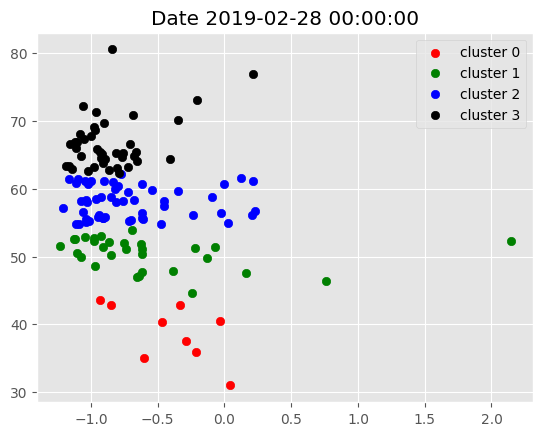

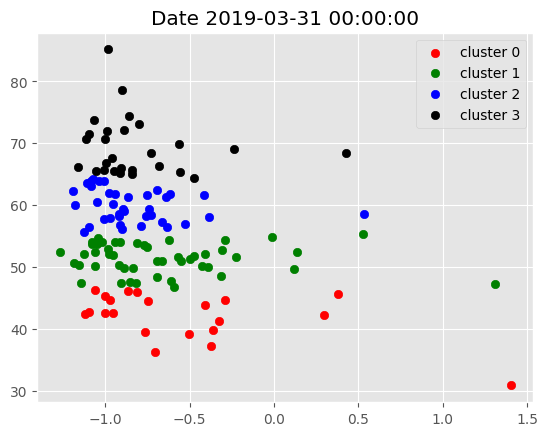

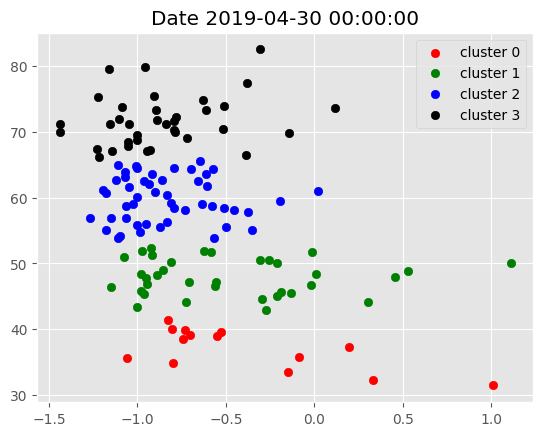

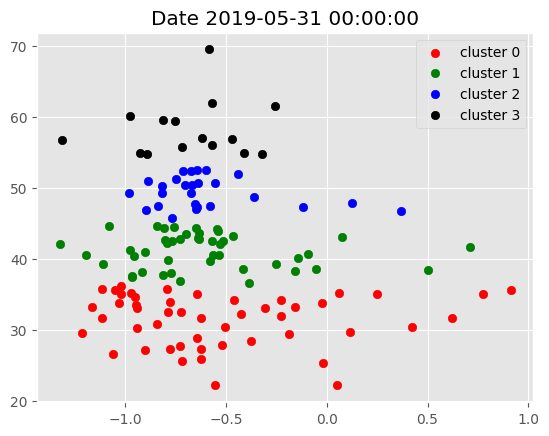

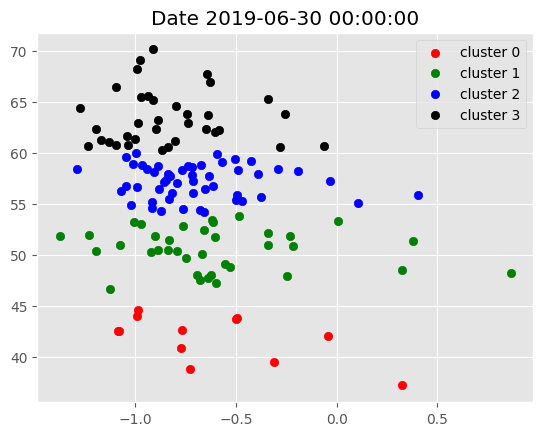

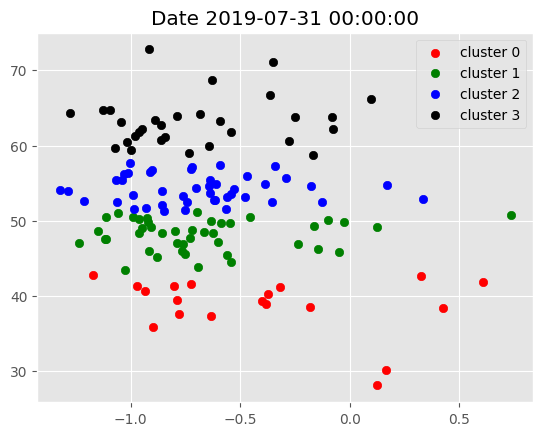

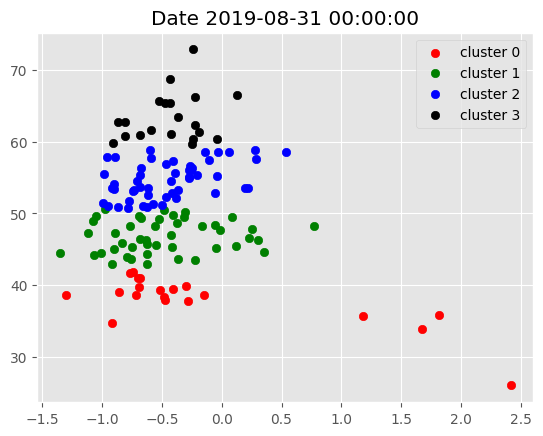

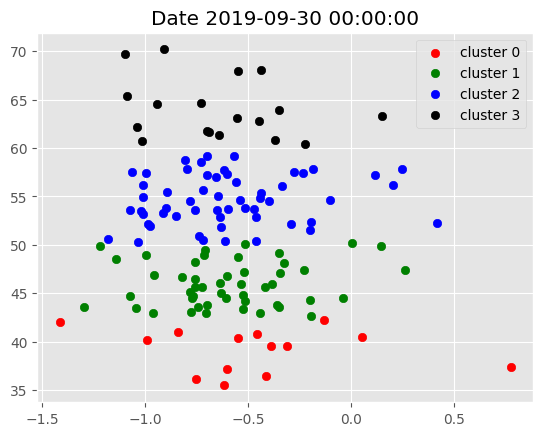

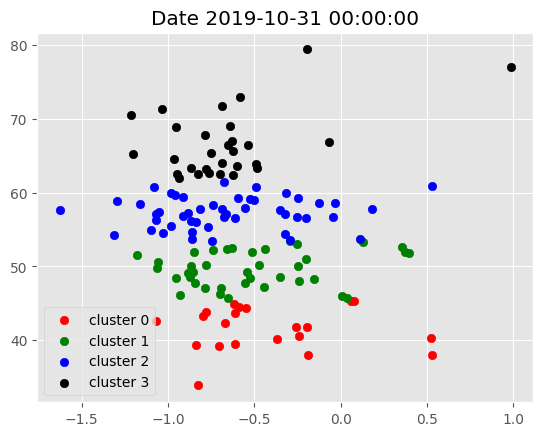

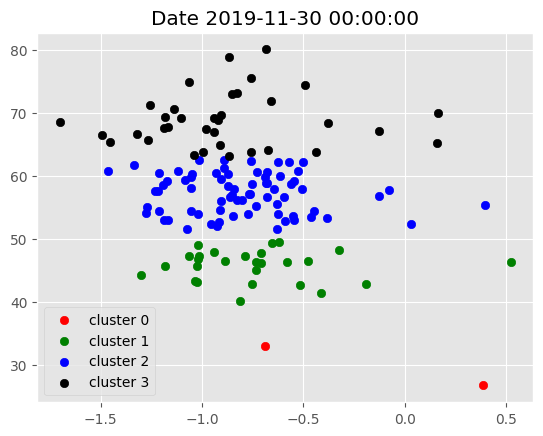

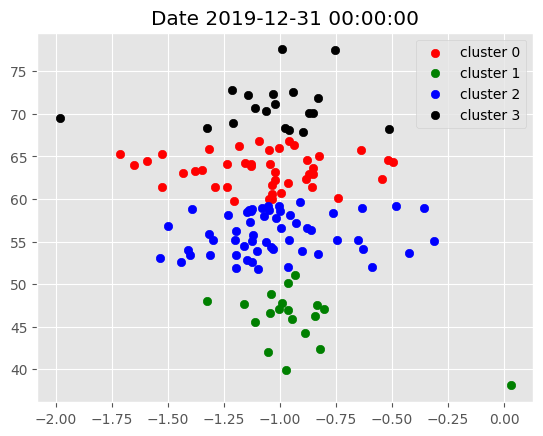

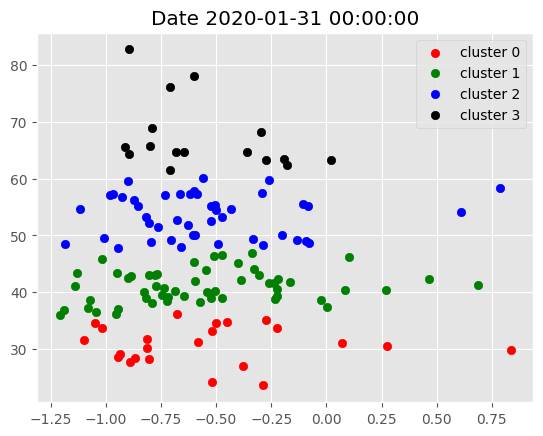

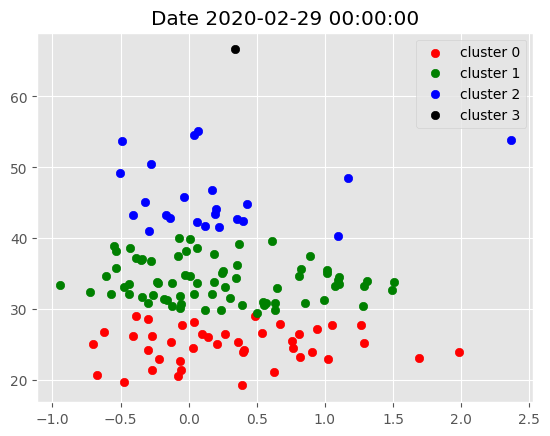

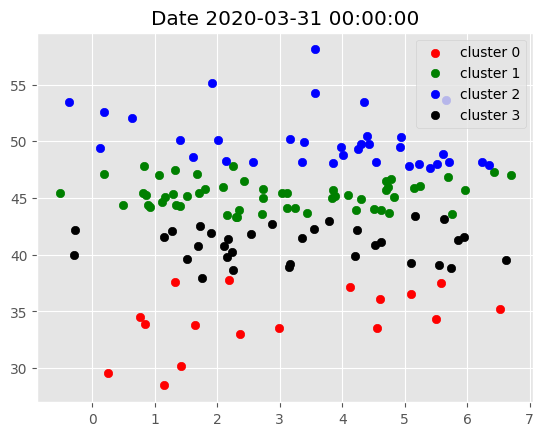

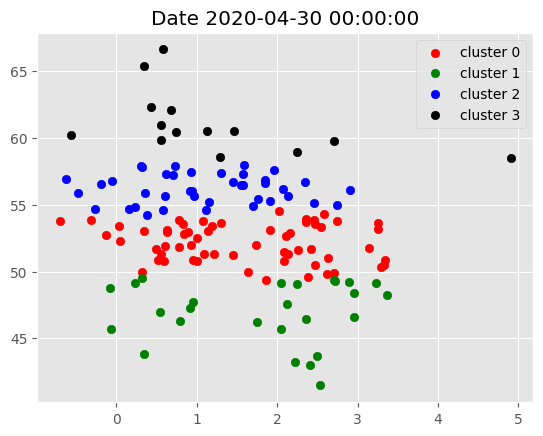

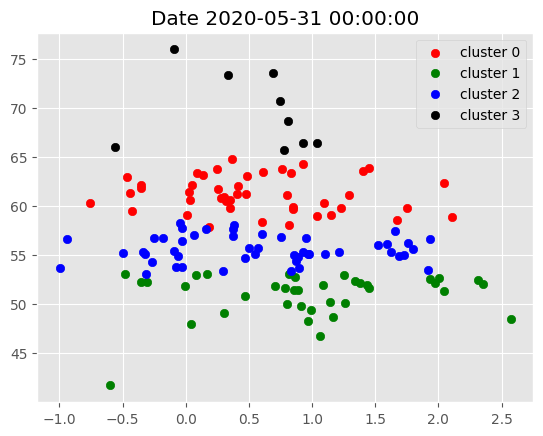

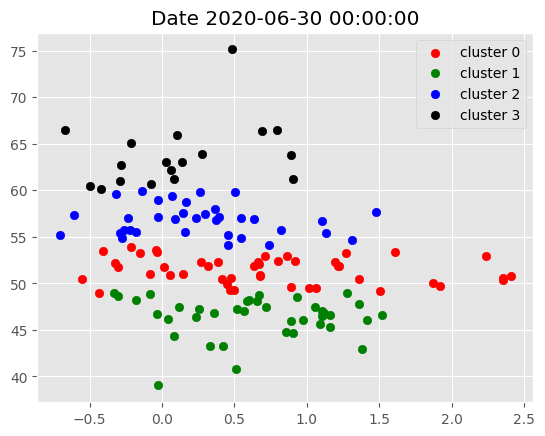

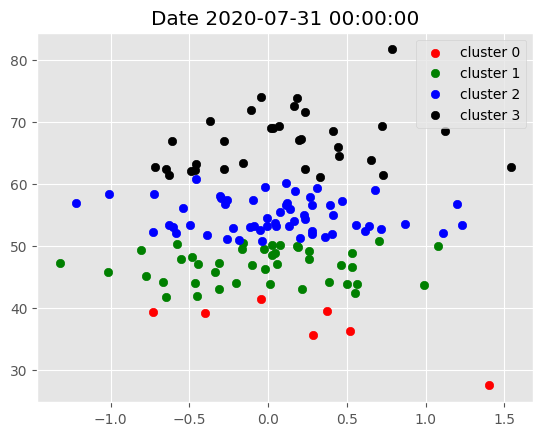

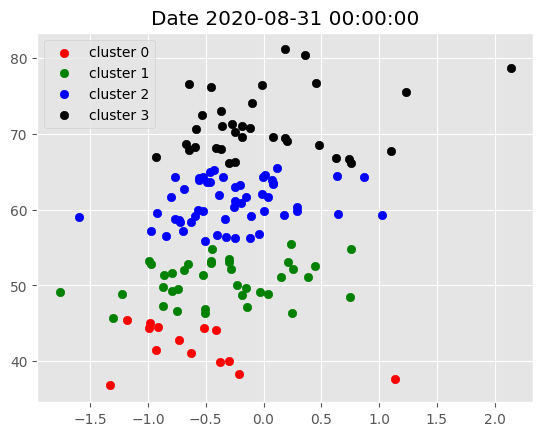

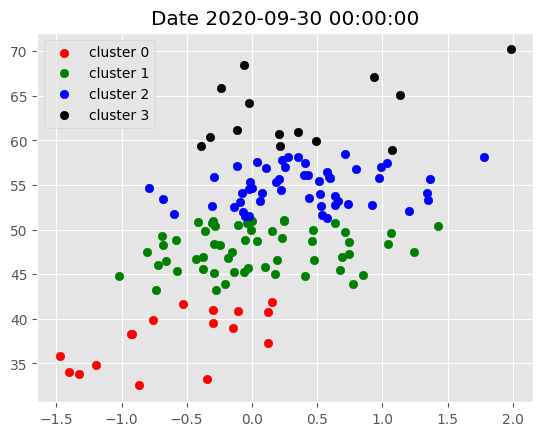

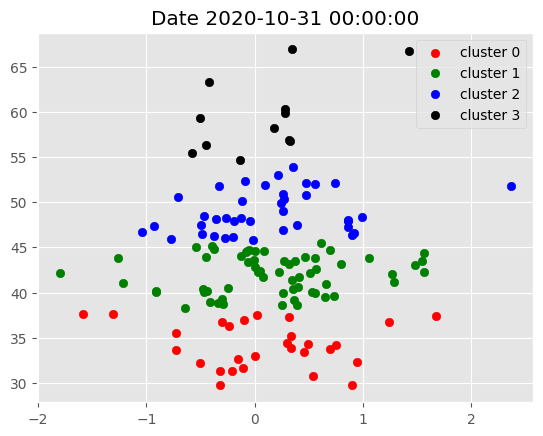

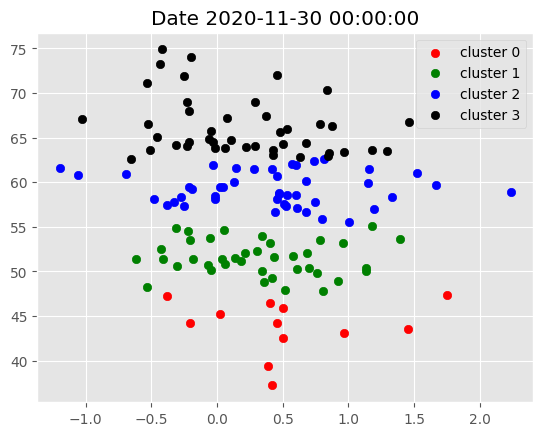

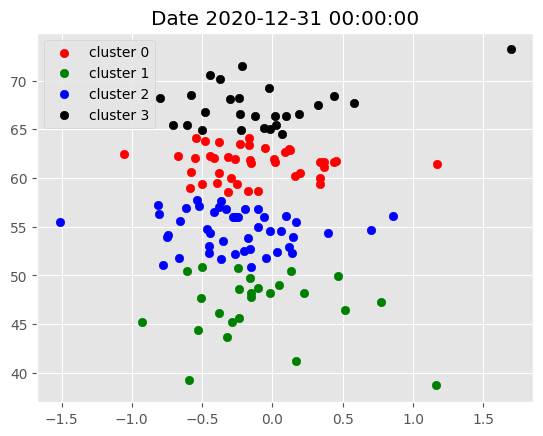

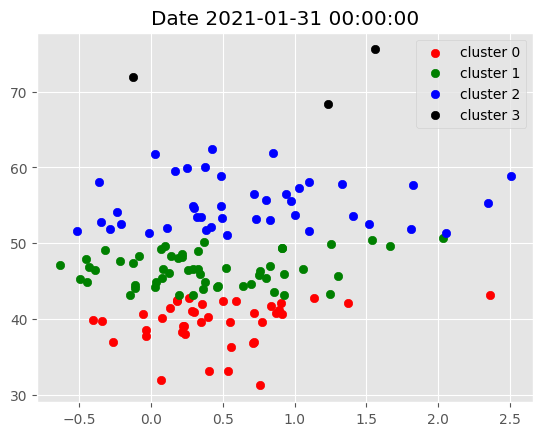

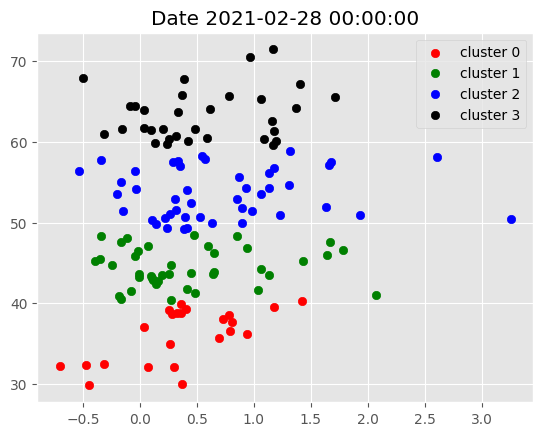

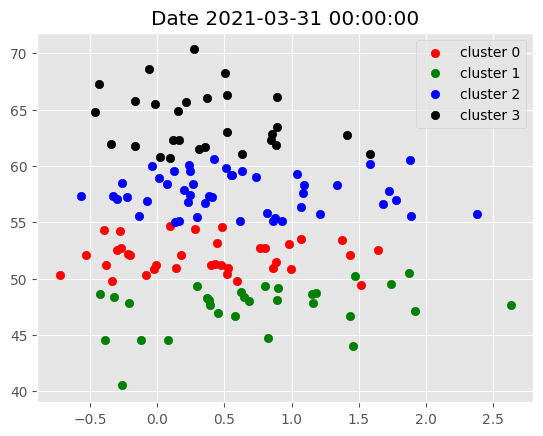

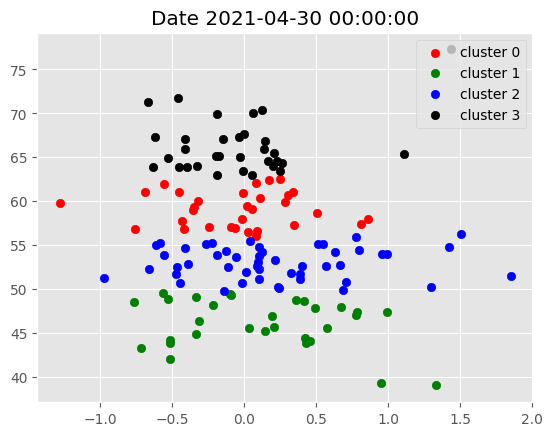

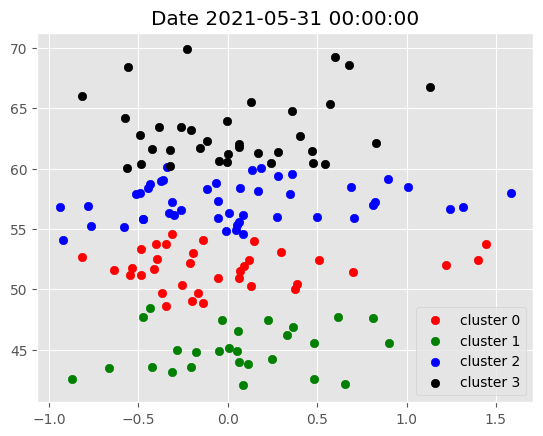

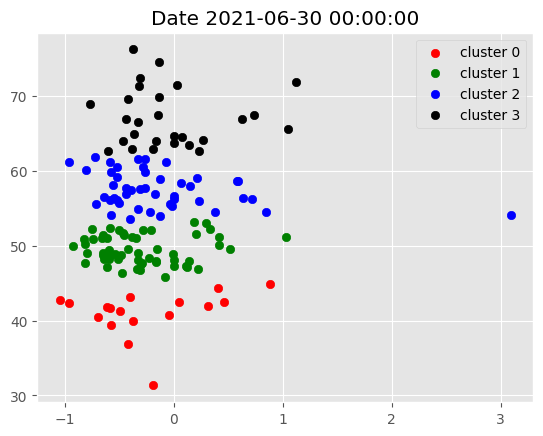

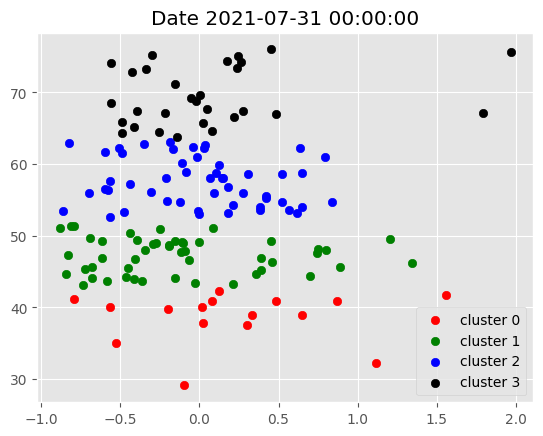

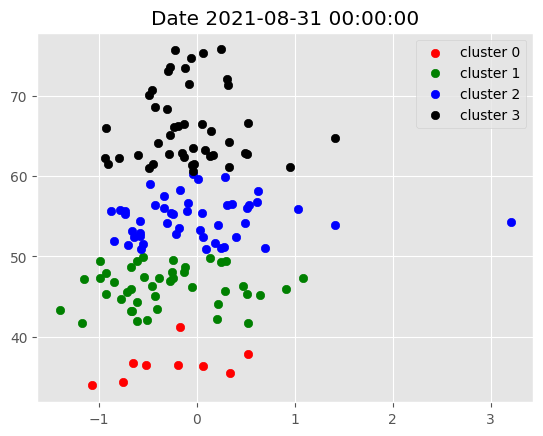

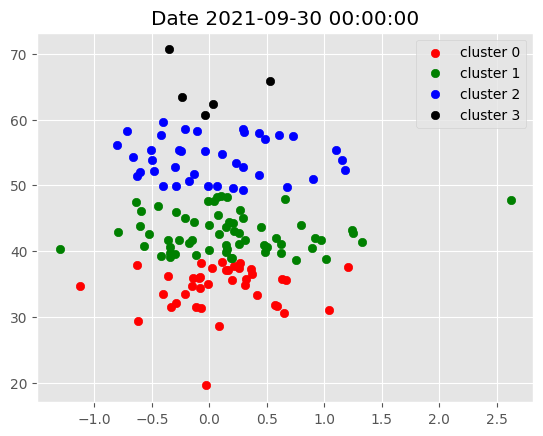

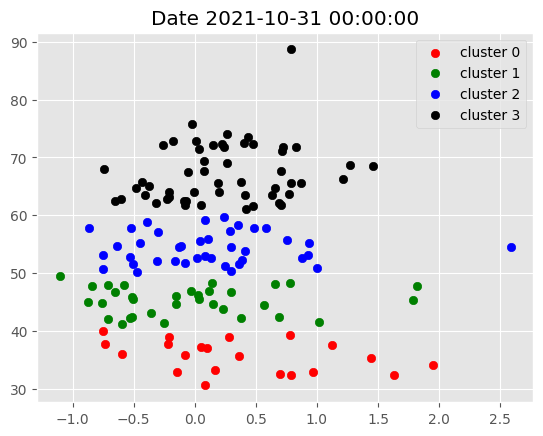

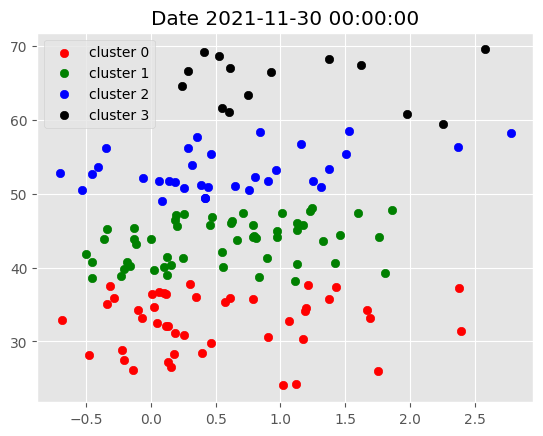

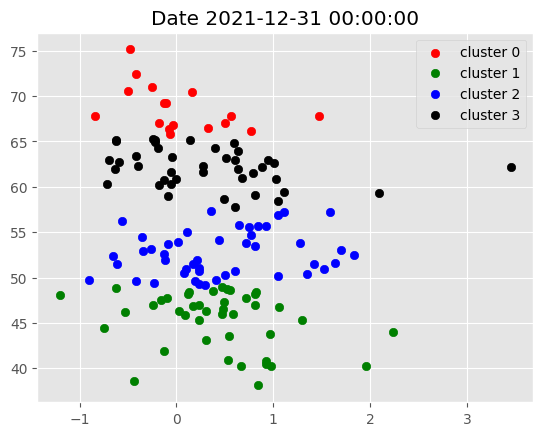

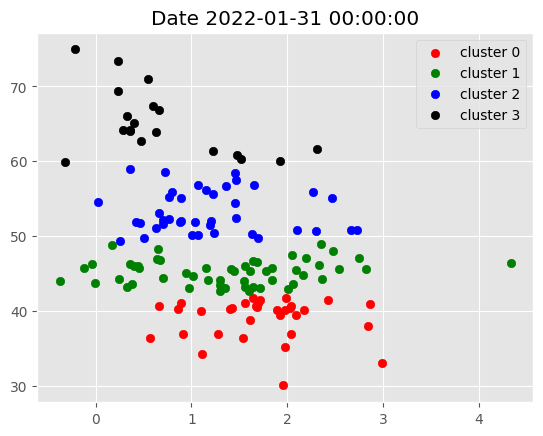

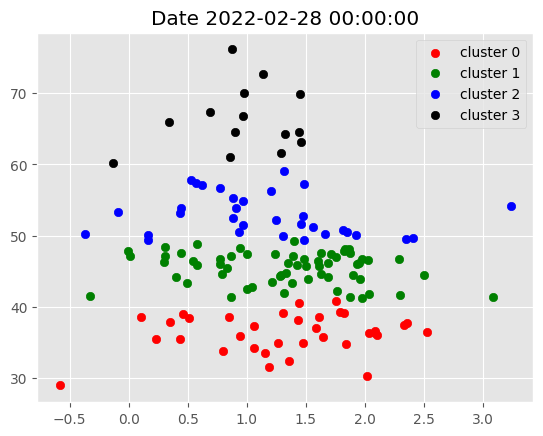

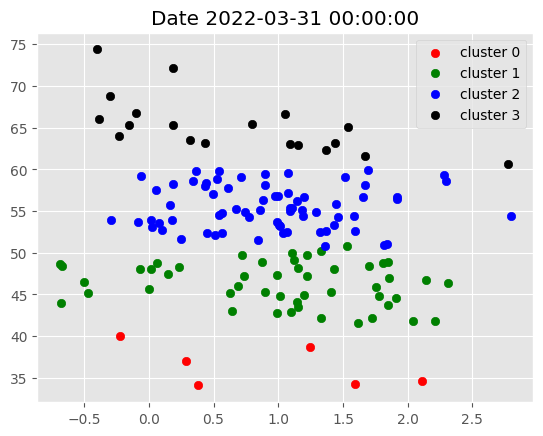

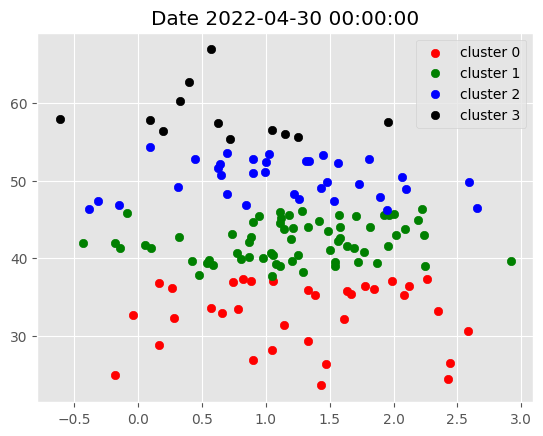

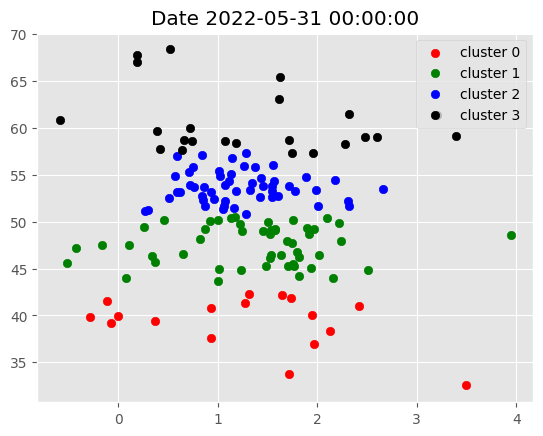

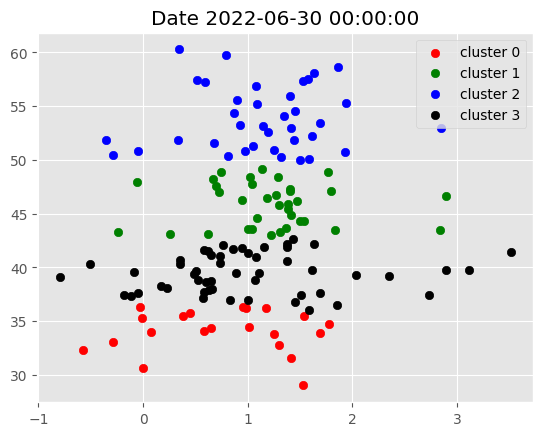

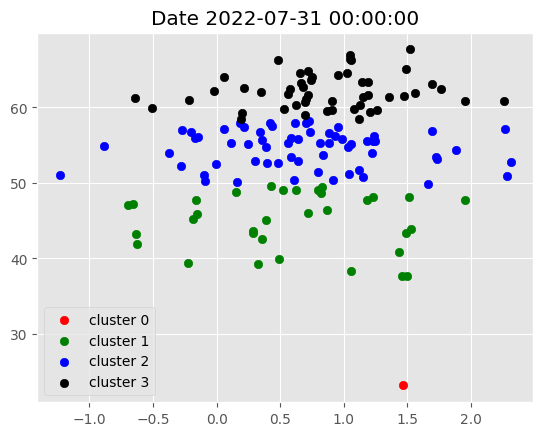

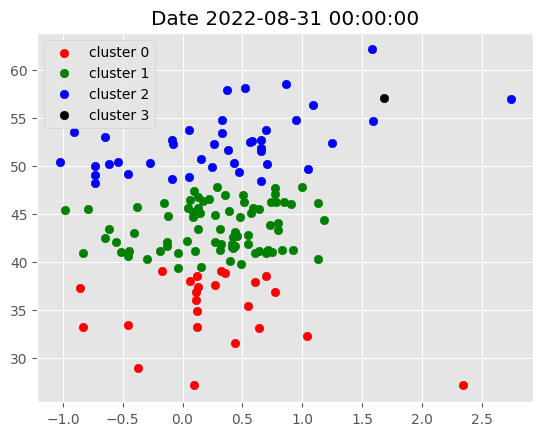

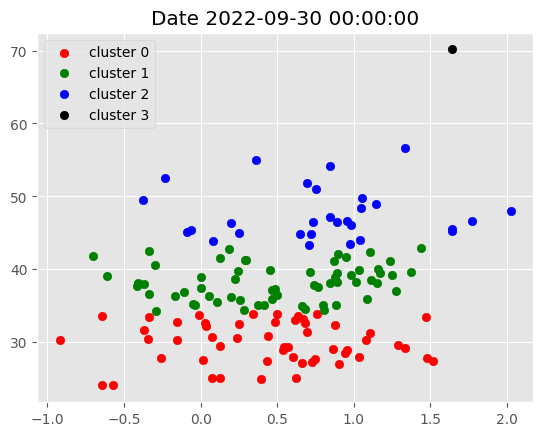

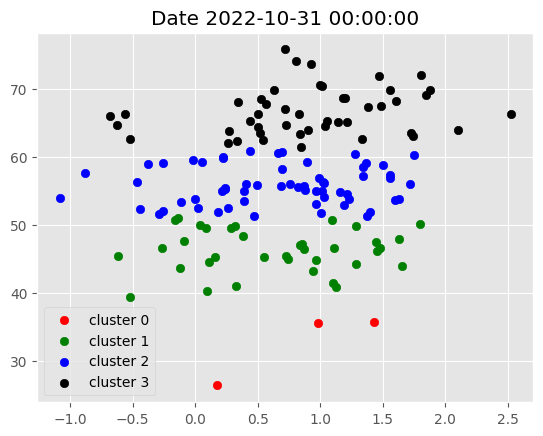

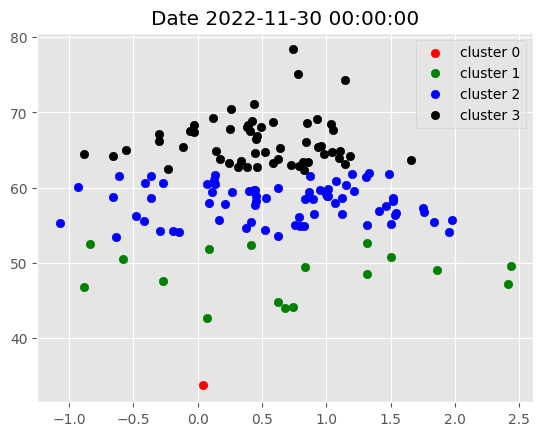

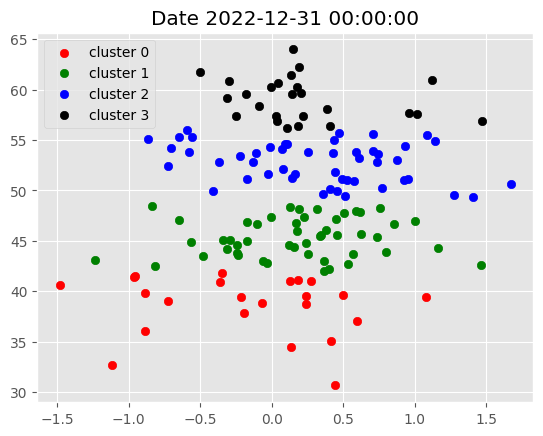

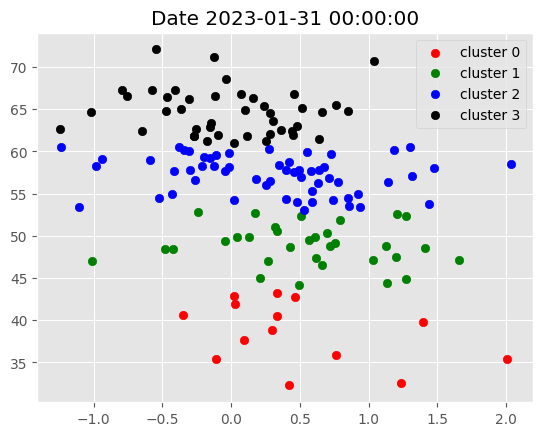

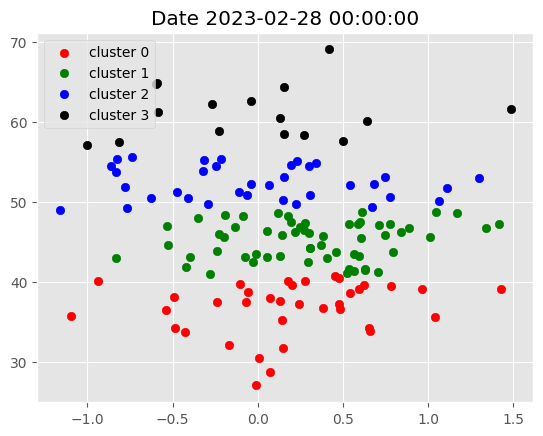

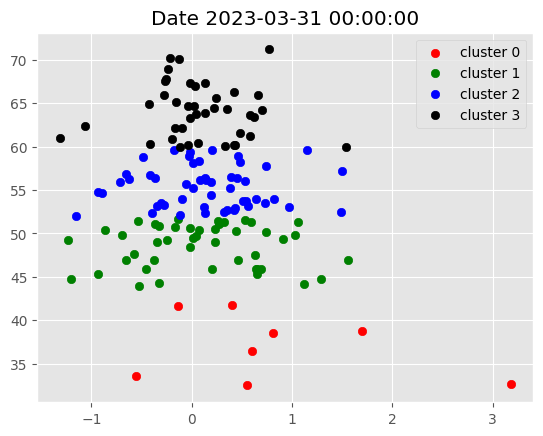

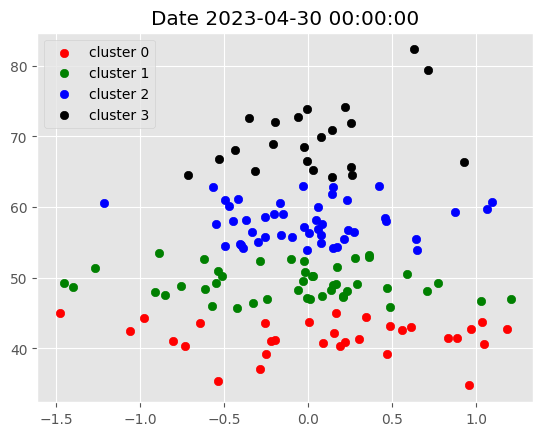

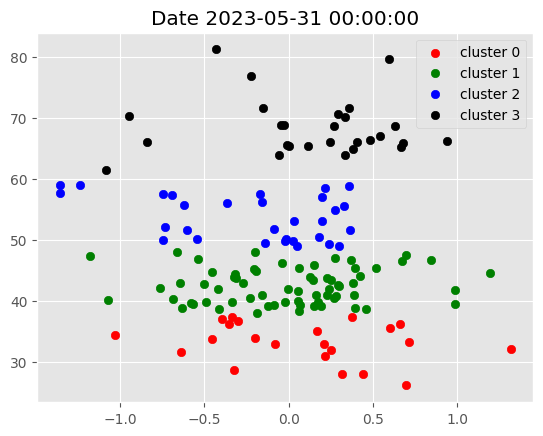

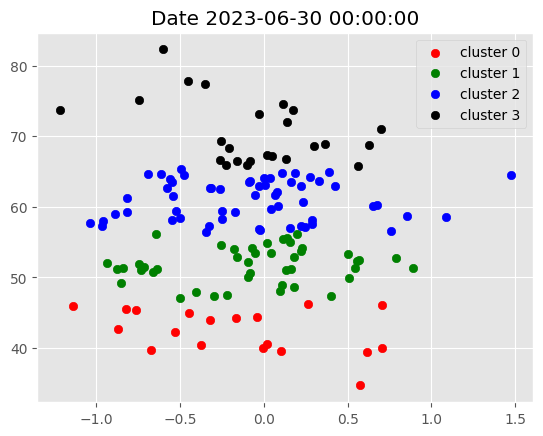

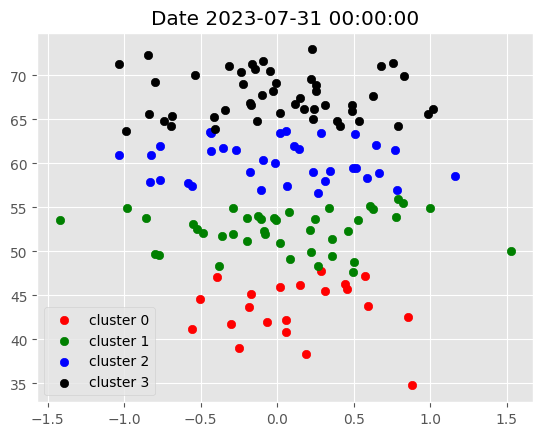

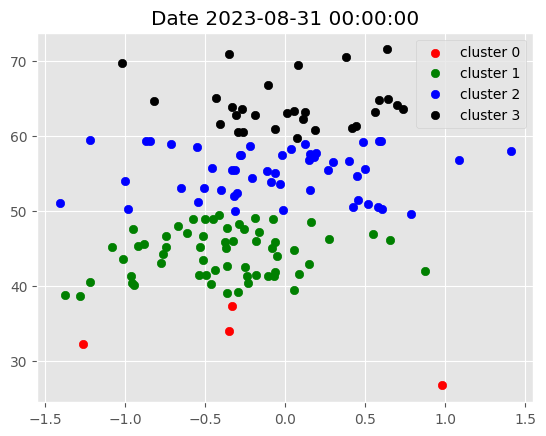

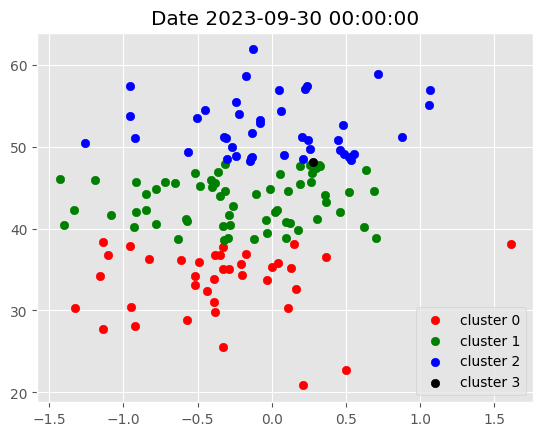

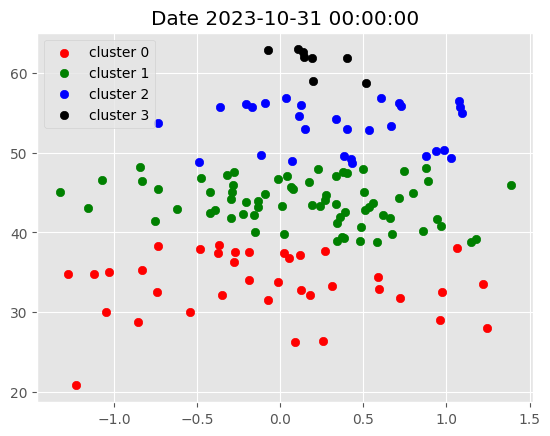

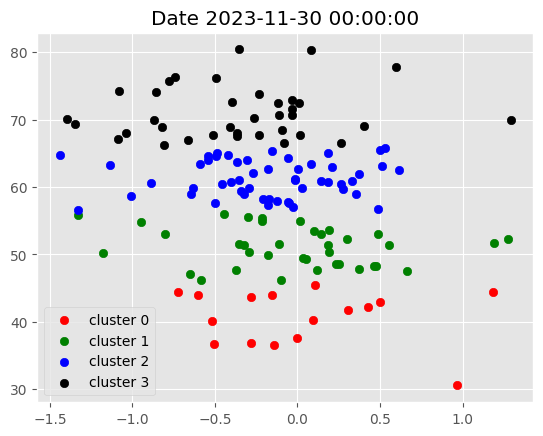

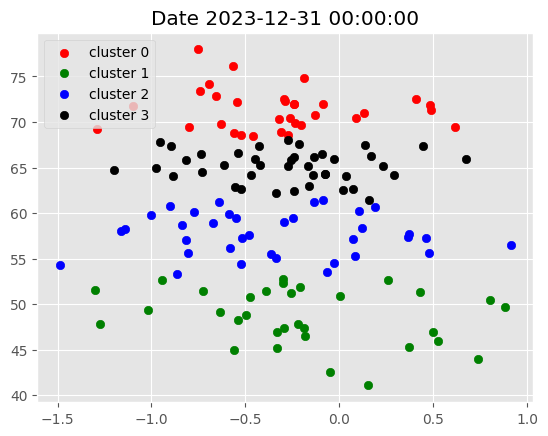

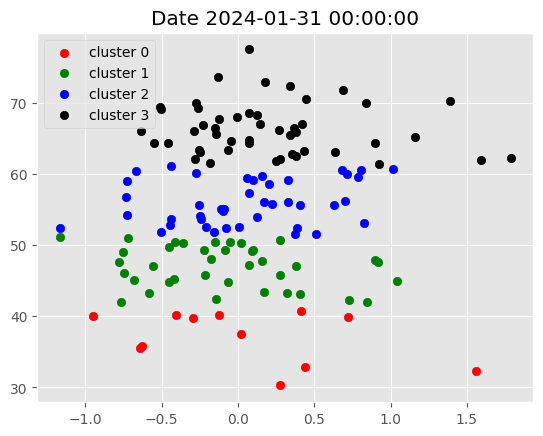

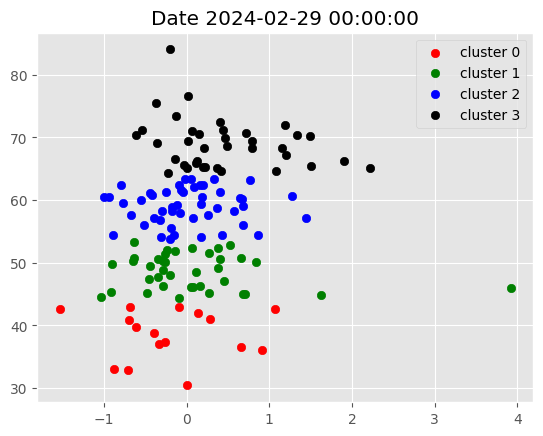

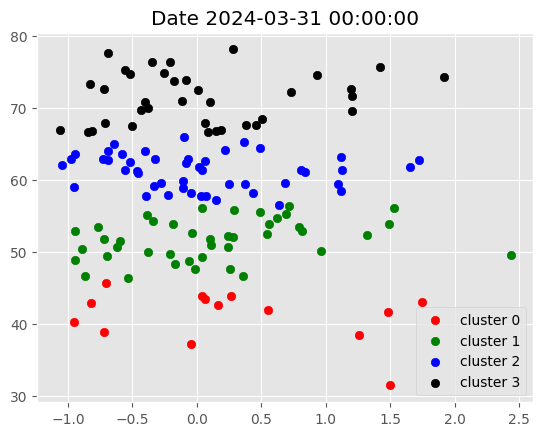

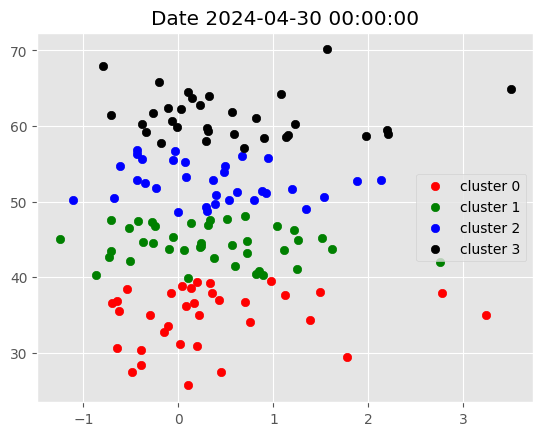

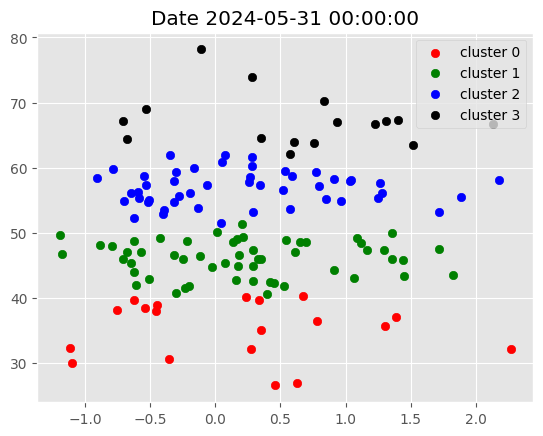

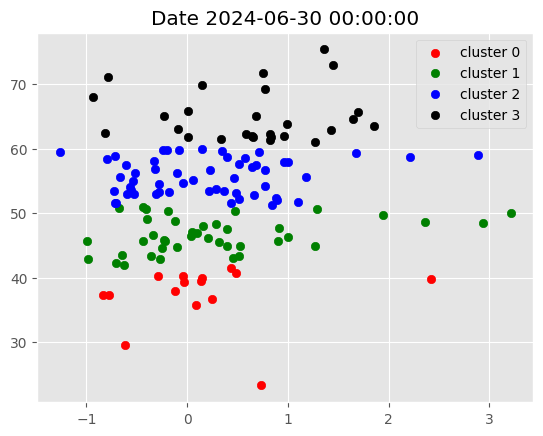

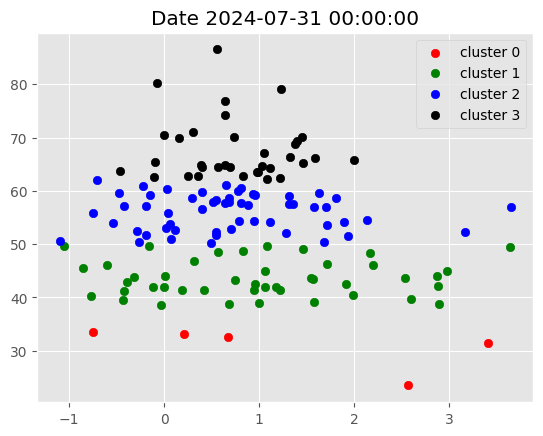

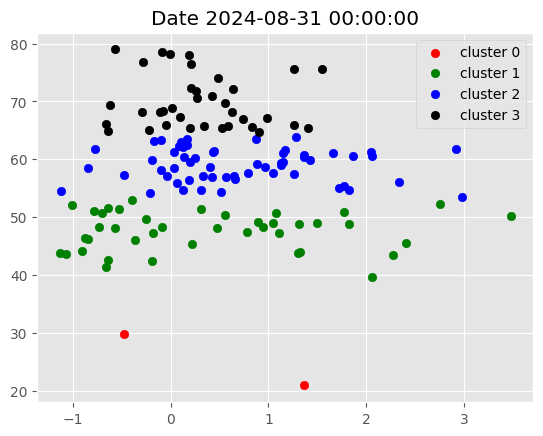

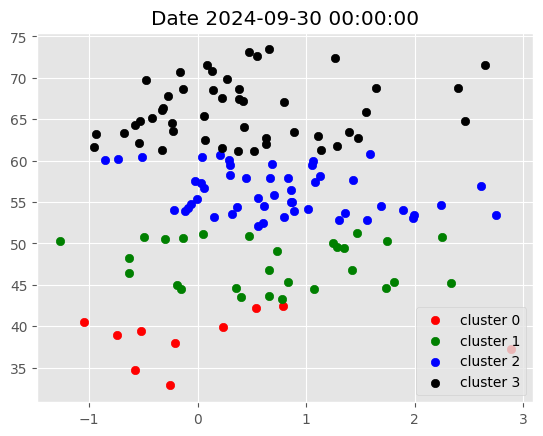

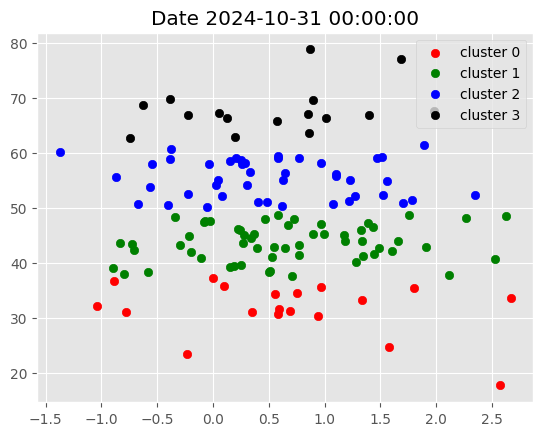

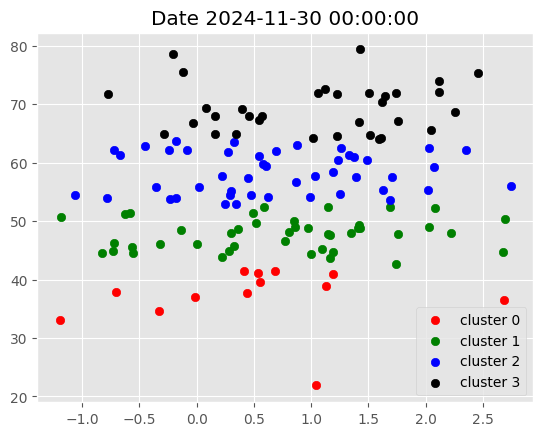

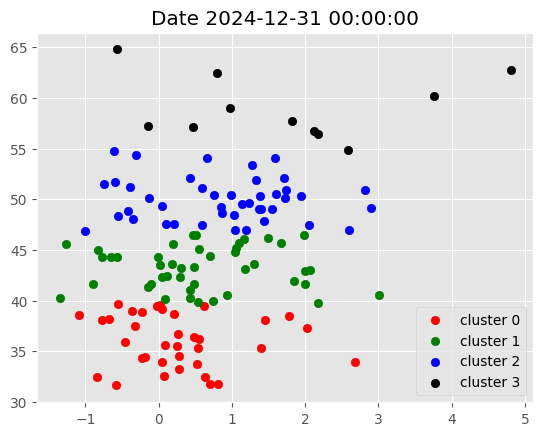

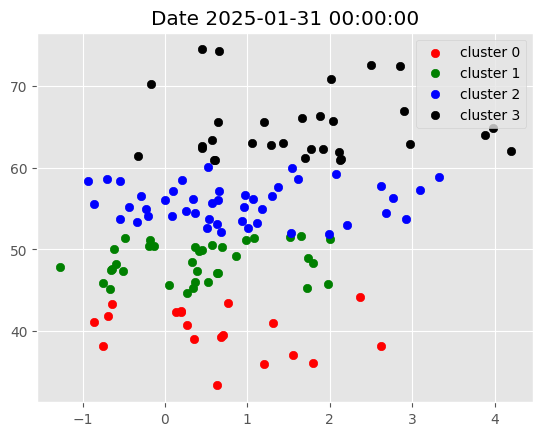

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist(): # for each month in date col., rsi is used for clustering to check stocks momentum

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

    #higher rsi clusters with good stocks momentum 60 to 70, 75.



* Cluster 3 stocks are having good momentum for the consistent months with rsi 70



## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [ ]:
filtered_df = data[data['cluster']==3].copy()
filtered_df
filtered_df = filtered_df.reset_index(level=1)
filtered_df
filtered_df.index = filtered_df.index+pd.DateOffset(1) # shift the last day of the month to the beginning of the next month
filtered_df
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
filtered_df
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist() # index is tickers

fixed_dates

{'2019-03-01': ['ABT',
  'ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'ALGN',
  'AMT',
  'AXP',
  'AZO',
  'BA',
  'BLK',
  'CHTR',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'DHR',
  'EBAY',
  'HON',
  'IBM',
  'INTC',
  'INTU',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MRK',
  'NEE',
  'NKE',
  'NOC',
  'ORCL',
  'PANW',
  'PM',
  'PYPL',
  'TMO',
  'ULTA',
  'UNP',
  'V',
  'XOM'],
 '2019-04-01': ['ACN',
  'ADP',
  'ALGN',
  'AMT',
  'AVGO',
  'AZO',
  'CMG',
  'COST',
  'CSCO',
  'DHR',
  'DLTR',
  'HON',
  'INTU',
  'LOW',
  'MA',
  'MCD',
  'MDLZ',
  'MO',
  'MRK',
  'PEP',
  'PG',
  'PYPL',
  'SBUX',
  'TGT',
  'TMO',
  'ULTA',
  'V'],
 '2019-05-01': ['ACN',
  'ADBE',
  'ADSK',
  'ALGN',
  'AMZN',
  'AXP',
  'BLK',
  'BRK-B',
  'C',
  'CHTR',
  'CMCSA',
  'CSX',
  'DIS',
  'DLTR',
  'F',
  'HON',
  'JPM',
  'KO',
  'LMT',
  'LRCX',
  'MA',
  'MAR',
  'MCD',
  'MDLZ',
  'META',
  'MS',
  'MSFT',
  'NOW',
  'PEP',
  'PYPL',
  'QCOM',
  'RTX',
  'SBUX',
  'STZ',
  'USB',
  'V'],

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [ ]:
# !pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252) # 252= 1 year of trading data

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                     auto_adjust=False)

new_df

[*********************100%***********************]  153 of 153 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EOG']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2018-02-28   42.073761   84.961647   53.386948  145.122131  209.130005   
2018-03-01   41.336781   83.501984   52.024181  140.741684  206.029999   
2018-03-02   41.622597   84.382179   52.617073  141.958466  209.789993   
2018-03-05   41.766693   84.836960   53.422333  143.175278  211.160004   
2018-03-06   41.731258   84.030090   53.873646  142.436203  212.009995   
...                ...         ...         ...         ...         ...   
2025-01-16  228.259995  173.699997  113.910004  350.559998  426.929993   
2025-01-17  229.979996  171.559998  113.480003  352.589996  429.989990   
2025-01-21  222.639999  172.610001  116.790001  356.420013  436.359985   
2025-01-22  223.830002  169.199997  117.779999  359.109985  437.320007   
2025-01-23  223.660004  170.669998  123.220001  363.260010  437.279999   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        ALGN        AMAT  ...   
Date                                                                    ...   
2018-02-28   79.015083   99.535431  117.470001  262.519989   53.212646  ...   
2018-03-01   77.402367   98.214851  114.739998  245.550003   52.732162  ...   
2018-03-02   78.471680   98.050858  116.279999  253.710007   53.619202  ...   
2018-03-05   79.882820   99.828903  118.870003  255.490005   53.249603  ...   
2018-03-06   80.575249   99.613113  119.870003  255.970001   55.430222  ...   
...                ...         ...         ...         ...         ...  ...   
2025-01-16  215.020004  296.230011  290.079987  218.910004  186.479996  ...   
2025-01-17  219.160004  296.179993  291.450012  224.229996  192.050003  ...   
2025-01-21  221.449997  298.149994  296.910004  228.000000  192.869995  ...   
2025-01-22  224.080002  296.359985  301.450012  232.139999  195.509995  ...   
2025-01-23  228.350006  295.799988  301.079987  234.889999  190.699997  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC       WFC   
Date                                                                           
2018-02-28  2746800  2055500  22159100   8173100  3379400  3101300  17869100   
2018-03-01  3035900  2028700  28950200   7299800  2507300  3554500  28491000   
2018-03-02  3485000  2111900  17449900   4682100  2552700  2505400  22428500   
2018-03-05  4656700  1882400  15348400   7464700  2775000  3410600  20560900   
2018-03-06  2852300  2176800  13526900   4498300  2598300  6593600  23975900   
...             ...      ...       ...       ...      ...      ...       ...   
2025-01-16  3212400  1226100  24678300  18807000  1683600  5310300  22897900   
2025-01-17  2531300  1773600  24082100  34974400  1578000  7160500  20673700   
2025-01-21  2663600  1561100  25717600  50854600  1666400  7045600  21057700   
2025-01-22  4038200  1215400  31488900  20153400  2012600  9340500  11669500   
2025-01-23  3884200  1658000  25078800  17632800  2179700  7058000  12974700   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2018-02-28  42431100  2578000  17087800  
2018-03-01  56728800  2561500  15696700  
2018-03-02  57130200  4147600  15630300  
2018-03-05  40149600  2803600  14891000  
2018-03-06  33164100  1257600  10754300  
...              ...      ...       ...  
2025-01-16  13267700  1844800  10366600  
2025-01-17  15868200  3339700  19298500  
2025-01-21  23247500  2617200  20416300  
2025-01-22  15567100  2862600  15718000  
2025-01-23  14185200  1746100  13718400  

[1736 rows x 918 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
returns_dataframe
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d') #as we need prices of one year before the date for optimisation

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 0, num_vars: 53
Error in LDL initial factorization.
ERROR: init_lin_sys_work failure
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 0, num_vars: 47
Error in LDL initial factorization.
ERROR: i

Strategy Return
date                       
2019-03-01         0.005217
2019-03-04        -0.002881
2019-03-05        -0.000238
2019-03-06        -0.005929
2019-03-07        -0.003930
...                     ...
2025-01-16        -0.004456
2025-01-17         0.016871
2025-01-21         0.009402
2025-01-22         0.004396
2025-01-23         0.001911

[1441 rows x 1 columns]

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today(),
                  auto_adjust=False).stack().droplevel(1)
spy
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)
spy_ret
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2019-03-01         0.005217      0.006224
2019-03-04        -0.002881     -0.003644
2019-03-05        -0.000238     -0.001361
2019-03-06        -0.005929     -0.006076
2019-03-07        -0.003930     -0.008401
...                     ...           ...
2025-01-16        -0.004456     -0.001925
2025-01-17         0.016871      0.009990
2025-01-21         0.009402      0.009112
2025-01-22         0.004396      0.005606
2025-01-23         0.001911      0.005443

[1441 rows x 2 columns]

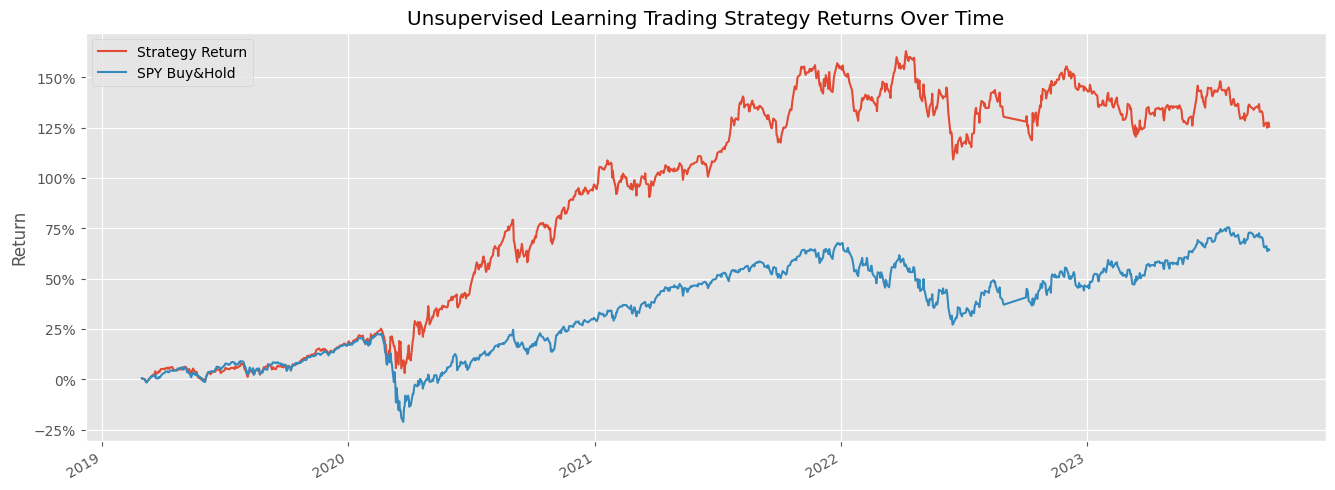

In [ ]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2025-01-23'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
